# **AI Engineer Assessment: Fintech Transaction Risk Intelligence System**

---

## **Task Overview**
This case study focuses on designing and implementing an **AI–driven fraud detection system** for transactions.  
Given a dataset of historical transactions labeled with `label_code`, the goal is to **predict probabiity of fraudulent or high-risk activity** while balancing precision, recall, and operational trade-offs.  

---

## **Aims & Objectives**

1. **Data Exploration & Understanding**  
   - Profile transaction data to uncover distributions, trends, and temporal patterns.  
   - Identify potential issues such as missing values, label noise, or ambiguous cases.  
   - Detect risks of temporal leakage or data drift that could undermine model reliability.  

2. **Feature Engineering & Selection**  
   - Engineer domain-relevant features such as time-based behavior, transaction velocity, and contextual metadata.  
   - Create meaningful interaction terms to capture non-linear fraud dynamics.  
   - Apply feature selection techniques to retain only the most informative predictors, improving model efficiency and interpretability.  
   - Document the rationale behind each transformation and selected feature.  

3. **Data Imbalance Identification & Mitigation**  
   - Analyze class distribution of `label_code` and quantify imbalance.  
   - Apply specialized strategies to address imbalance.

4. **Model Development**  
   - Establish baseline classifiers (Majority Voting Classifier) before progressing to more specialized models (Gradient Boosting, CatBoost,XGBoost) for predictive modeling of `label_code`.  .  
   - Incorporate safeguards against overfitting, such as cross-validation and regularization.  

5. **Model Evaluation & Business-Aligned Metrics**  
   - Evaluate models with relevant metrics such as **precision, recall, F1-score, AUROC, and AUC-PR**.   
   - Document trade-offs between false positives (customer friction) and false negatives (fraud losses).  

6. **Unsupervised Learning for Behavioral Segmentation**  
   - Apply clustering method (K-Means) to group users into behavioral clusters.  
   - Analyze cluster profiles to derive potential business insights (e.g., “high-frequency micro-transactions,” “cross-border spenders,” “infrequent large-value users”).  
   - Discuss the operational use cases of these clusters for adaptive fraud strategies and customer risk profiling.  

7. **Explainability & Interpretation**  
   - Use SHAP values and feature importance to provide transparency in model behavior.  
   - Deliver both **global** explanations (top drivers of fraud across the dataset) and **local** explanations (why a specific transaction was flagged).  
   - Support responsible AI use by documenting how explanations can inform analysts and compliance teams.  

8. **Deployment Simulation**  
   - Package the solution into two production-ready components:  
     - **Streamlit App** for interactive exploration, visualization of temporal fraud patterns, and scoring demo.  
     - **FastAPI Service** exposing a `/score` endpoint for real-time transaction-level risk scoring.  
   - Ensure reproducibility, versioning, and robustness of the deployed pipeline.  


---

##  **Methodology**
The methodology follows a structured ML project lifecycle:

1. **Data Preparation**  
   - Clean and preprocess data.  
   - Engineer features based on relevant variables.  

2. **Modeling & Validation**  
   - Train with temporal splits to prevent data leakage.  
   - Optimize for business-aware objectives: maximize recall while maintaining acceptable precision.  

3. **Explainability**  
   - Provide global and local explanations of model behavior to build trust and accountability.  

4. **Deployment & Demonstration**  
   - Deliver a reproducible pipeline and persisted model artifacts.  
   - Build both API and UI components for practical, real-world simulation.  

---

## **Expected Outcomes**
- A robust, explainable, and reproducible **fraud detection pipeline**.  
- Insights into **tfraud trends** and **user behavior**.  
- Documentation of methodology, assumptions, and future improvements.  
- Working **Streamlit demo** and **FastAPI service** that mimic production-ready deployment.

---


## **Tools**

In [57]:
# ================================
# Data Manipulation & Visualization
# ================================
import pandas as pd              # Data manipulation and analysis
import numpy as np               # Numerical computing and arrays
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns            # Statistical data visualization
import plotly.express as px      # Interactive visualizations 
from mpl_toolkits.mplot3d import Axes3D # 3D plotting
from scipy.stats import chi2_contingency  # Chi-squared test for independence

# ================================
# Preprocessing & Feature Engineering
# ================================
from sklearn.model_selection import  TimeSeriesSplit, cross_val_score                   # Data splitting & cross-validation
from sklearn.preprocessing import StandardScaler, OrdinalEncoder       # Scaling & encoding features
from sklearn.compose import ColumnTransformer                          # Combine preprocessing steps
from sklearn.pipeline import Pipeline                                  # Build reproducible ML workflows
from sklearn.decomposition import  PCA                                 # Dimensionality reduction
# ================================
#  Machine Learning Models
# ================================
from sklearn.dummy import DummyClassifier                              # Dunmmy classifier for Baseline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier  # Tree-based ensemble models
from xgboost import XGBClassifier                                      # Extreme Gradient Boosting
from lightgbm import LGBMClassifier                                    # LightGBM for fast gradient boosting
from catboost import CatBoostClassifier                                # CatBoost for categorical features

# ================================
# Evaluation & Metrics
# ================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, precision_recall_curve, confusion_matrix,
    classification_report, roc_curve, auc, log_loss, euclidean_distances,
    silhouette_score,make_scorer
)   # Metrics to evaluate fraud detection models

# ================================
#  Imbalance Handling
# ================================
from sklearn.utils.class_weight import compute_class_weight         # Compute class weights for cost effective learning

# ================================
# Explainability
# ================================
import shap                                                           # SHAP values for model explainability

# ================================
# 🧭 Unsupervised Learning
# ================================
from sklearn.cluster import KMeans                                    # Clustering for behavioral segmentation             

# ================================
# ⚠️ Utilities
# ================================
import os                                                              # file paths, environment variables and directory management)
from itertools import product                                          # Cartesian product for parameter tuning
import joblib                                                         # loading and saving models and artifacts
from collections import Counter                                       # Counting hashable objects
import warnings
warnings.filterwarnings("ignore")                                      # Suppress warnings for cleaner output
import sys                                                             # System-specific parameters and functions



**Environment & Display Configuration**


In [2]:
# 
sys.path.append(os.path.abspath("./src"))                              # Add src directory to Python path   
pd.set_option("display.float_format", "{:.2f}".format)                 # Format float values
pd.set_option('display.max_columns', None)                             # Show all columns
pd.set_option('display.expand_frame_repr', False)                      # Prevent line breaks
pd.set_option('display.width', 1000)                                   # Set a wider display
warnings.simplefilter(action='ignore', category=FutureWarning)         # Suppress future warnings

## **Data Exploration & Understanding** 
In this section, we lay the foundation for the modeling task by carefully examining the dataset. The goal is to understand the structure, quality, and underlying patterns in the data to better infer feature engineering and modeling strategies. 

### **Dataset Overview**
First we consider the following:
- Inspect the dataset’s dimensions (rows × columns) and available features.  
- Identify variable types (categorical, numerical, temporal, target) and convert them into appropriate formats.  
- Explore the number of distinct values in categorical features, summarize the statistical properties of numerical variables and confirm the date range of the transactions.  
- Check for missing data, duplicate rows, and other potential data quality issues.


In [3]:
# Load your dataset
data = pd.read_excel('./src/data/fintech_sample_fintech_transactions.xlsx')  

# preview dataset
data.head()

,transaction_id,customer_id,transaction_amount,transaction_type,device_type,location,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,risk_score
0,TX100703,CUST1092,5.28,Online,Mobile,Abuja,Afternoon,Fri,0,1,0,1,2024-02-04 22:00:00,0.08
1,TX100182,CUST1021,205.16,Online,ATM Machine,Lagos,Evening,Tue,0,0,0,0,2024-01-17 04:00:00,2.36
2,TX100221,CUST1100,77.72,POS,POS Terminal,Ibadan,Morning,Wed,0,1,0,1,2024-01-13 15:00:00,1.79
3,TX100528,CUST1099,8.44,ATM,POS Terminal,Kano,Evening,Sun,0,0,0,0,2024-01-18 06:00:00,0.10
4,TX100776,CUST1014,11.13,Online,POS Terminal,Port Harcourt,Night,Sun,1,0,0,1,2024-02-05 07:00:00,0.18


In [4]:
# check the dimensions of the data
n_rows, n_cols = data.shape
print(f'There are {n_rows:,} samples and {n_cols} variables in the dataset')

There are 1,000 samples and 14 variables in the dataset


In [5]:
# check the variables in the dataset
print(f'The variables in the dataset are:')
list(data.columns)

The variables in the dataset are:


['transaction_id',
 'customer_id',
 'transaction_amount',
 'transaction_type',
 'device_type',
 'location',
 'time_of_day',
 'day_of_week',
 'is_foreign_transaction',
 'is_high_risk_country',
 'previous_fraud_flag',
 'label_code',
 'transaction_time',
 'risk_score']

In [6]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_id          1000 non-null   object        
 1   customer_id             1000 non-null   object        
 2   transaction_amount      1000 non-null   float64       
 3   transaction_type        1000 non-null   object        
 4   device_type             1000 non-null   object        
 5   location                1000 non-null   object        
 6   time_of_day             1000 non-null   object        
 7   day_of_week             1000 non-null   object        
 8   is_foreign_transaction  1000 non-null   int64         
 9   is_high_risk_country    1000 non-null   int64         
 10  previous_fraud_flag     1000 non-null   int64         
 11  label_code              1000 non-null   int64         
 12  transaction_time        1000 non-null   datetime6

The dataset contains 1,000 transaction records and there seems to be no missing values.. It includes identifiers (`transaction_id` and `customer_id`), categorical attributes such as `transaction type`, `transaction location` and `device type`, numeric features like `transaction amount` and `risk score`, binary indicators related to fraud risk such (`is_high_risk_country`, `previous_fraud_flag`) and a temporal field for transaction time as well as time indicators (`day of the week`, `time of the day`). The target variable `label_code` is already encoded as binary, which simplifies supervised modeling. Overall, the dataset is lightweight, well-structured, and provides a balanced mix of categorical, numerical, and temporal information suitable for fraud detection analysis.

We would define the variables by types (in list formats) and explore the distinct values in each variable based on their type for a more granular data understanding.

In [7]:
# Define target variable
target_var = 'label_code'

# Define list of categorical variables
categorical_vars = ['customer_id', 'transaction_type', 'device_type','location',
                    'is_foreign_transaction', 'is_high_risk_country','previous_fraud_flag', 
                    'time_of_day', 'day_of_week']


# Convert the columns to categorical type
data[categorical_vars] = data[categorical_vars].astype('category')

# Define list of numerical variables
numerical_vars = ['transaction_amount', 'risk_score']

# Define list of temporal variables
temporal_vars = ['transaction_time']

**Categorical Data Overview: Distinct Values**

In [8]:
# Show distinct values for categorical variables
def show_distinct_values(data, categorical_vars, extra_vars=None, max_show=10):
    """
    Show distinct values and counts for categorical variables in a dataset.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing the data.
    categorical_vars : list
        List of categorical variable names.
    extra_vars : list, optional
        Additional variables to check (e.g., label column).
    max_show : int, default=5
        Number of sample distinct values to display if values exceed 10.
    """
    vars_to_check = categorical_vars + ([extra_vars] if extra_vars else [])

    for var in vars_to_check:
        print(f"{var}:")
        len_distinct = data[var].nunique()
        print(f"There are {len_distinct} distinct values in {var}")
        
        if len_distinct > max_show:
            print(f"Some distinct values in {var} are: {list(data[var].unique())[:max_show]}")
        else:
            print(list(data[var].unique()))
        print()

show_distinct_values(data, categorical_vars, extra_vars=target_var)

customer_id:
There are 101 distinct values in customer_id
Some distinct values in customer_id are: ['CUST1092', 'CUST1021', 'CUST1100', 'CUST1099', 'CUST1014', 'CUST1052', 'CUST1017', 'CUST1037', 'CUST1091', 'CUST1004']

transaction_type:
There are 4 distinct values in transaction_type
['Online', 'POS', 'ATM', 'Transfer']

device_type:
There are 4 distinct values in device_type
['Mobile', 'ATM Machine', 'POS Terminal', 'Web']

location:
There are 5 distinct values in location
['Abuja', 'Lagos', 'Ibadan', 'Kano', 'Port Harcourt']

is_foreign_transaction:
There are 2 distinct values in is_foreign_transaction
[0, 1]

is_high_risk_country:
There are 2 distinct values in is_high_risk_country
[1, 0]

previous_fraud_flag:
There are 2 distinct values in previous_fraud_flag
[0, 1]

time_of_day:
There are 4 distinct values in time_of_day
['Afternoon', 'Evening', 'Morning', 'Night']

day_of_week:
There are 7 distinct values in day_of_week
['Fri', 'Tue', 'Wed', 'Sun', 'Thu', 'Mon', 'Sat']

label_c

The dataset shows a mix of categorical and binary variables with varying cardinality. There are 101 unique customers identified in the dataset (that's an average of 10 transactions per customers across that period), making it a high-cardinality categorical feature that will require encoding strategies such as target or frequency encoding rather than simple one-hot encoding. Other categorical variables like transaction_type, device_type, location, time_of_day, and day_of_week have relatively few distinct categories, so they can be safely one-hot encoded. Binary indicators such as `is_foreign_transaction`, `is_high_risk_country`, and `previous_fraud_flag` are already numeric and need no transformation. The target variable `label_code`. Overall, the features show low cardinality and categorical encoding will be essential to transform them into a form suitable for machine learning. 

**Numerical Data Overview: Basic/Summary Statistics**

In [9]:
# Show basic statistics of numerical variables
data[numerical_vars].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
transaction_amount,1000.00,72.60,73.35,-17.07,21.04,50.38,102.79,608.38
risk_score,1000.00,0.75,0.82,-0.29,0.20,0.49,1.04,8.57


**Insights from numerical summary statistics**
* **Transaction Amount**: Wide variations in the distribution with negative values (possible refunds or errors). → Would require transformation (e.g., log scaling) if considered relevant feature for modelling and removal of negative values since there are no additional context of what they infer.
* **Risk Score**: Mostly concentrated near 0.5–1 but with a heavy right tail up to 8+. → Right skewed distribution suggests scaling or transformation to stabilize variance.
* **Preprocessing Implications**: Need to apply normalization for numerical variables, handle negative values, and consider feature engineering (e.g. interaction terms).
* **Modeling Implications**: Tree-based models can handle skewness, while linear models would require transformations. Extreme values may hold fraud signals, so we should avoid over-aggressive trimming.


**Temporal Data Overview: Time Range**

In [10]:
# Convert transaction_time column to datetime
data["transaction_time"] = pd.to_datetime(data["transaction_time"], errors="coerce")

# Verify date range
print(
    f"Transaction time covers {data['transaction_time'].min()} → {data['transaction_time'].max()}"
)

Transaction time covers 2024-01-01 00:00:00 → 2024-02-11 15:00:00


The transaction timestamps span just over **six weeks**, from January to mid-February 2024, which indicates that the dataset represents a relatively short observation window. This means that while temporal features can be meaningfully engineered for short-term transaction velocities, long-term seasonality or quarterly trends will not be captured. It also suggests we need to be mindful of **temporal leakage** when splitting the data, ensuring training and validation sets respect this chronological order.


We would derive further temporal features from our transaction time that could provide relevant short term customer behavioural patterns to our fraud model

In [11]:
# Derive temporal features
data["_hour"] = data["transaction_time"].dt.hour
data["_day"] = data["transaction_time"].dt.day
data["_month"] = data["transaction_time"].dt.month
data["_is_weekend"] = (data["transaction_time"].dt.dayofweek >= 5).astype(int)

In [12]:
# Map weekend and month names for readability
month_map = {1: "January", 2: "February"}
data["_month_name"] = data["_month"].map(month_map)
data["_weekend_name"] = data["_is_weekend"].map({0: "Weekday", 1: "Weekend"})

In [13]:
# Add derived features to temporal_vars
temporal_vars += ['_hour', '_day']

# Treat others as categorical features (for convineince)
categorical_vars += ['_month_name', '_is_weekend']

**Data Quality Checks: Missing & Duplicate Records**

Confirm that there are no missing values in the dataset and check for possible transaction duplicates

In [14]:
# Check for possible missing data
data.isnull().any().any()

False

In [15]:
# Check for duplicate data
data.duplicated().any()

False

### **Exploratory Data Analysis**

After the initial data overview, we would do a deeper exploration of our dataset to better understand its distributions, structure, patterns, trends and relationships across all the variables. 
This includes:
   - **Target Variable:** Assess the class distribution of `label_code` (fraud vs. non-fraud) and visualize it to highlight possible class imbalance.  
   - **Numerical Variables:** Perform univariate analysis (distribution, skewness, kurtosis) and multivariate analysis (correlation, class-wise distributions).  
   - **Categorical Variables:** Explore frequency counts, relationships with the target, and compute correlations using metrics such as Cramér’s V.  
   - **Temporal & Customer-Level Insights:** Investigate fraud rates and trends over time.  

#### **Target Variable**

**Class Distribution**

In [16]:
# Map numeric labels to tags
label_map = {0: "No Fraud", 1: "Fraud"}

# Map target variable
data["Label"] = data[target_var].map(label_map)

In [17]:
# Get counts of each label
label_count = data["Label"].value_counts()

# Shows class distribution
label_count.apply(lambda x: f'{x:,}')

Label
No Fraud    829
Fraud       171
Name: count, dtype: object

In [18]:
# Create a donut chart of label distribution
fig = px.pie(
    values=label_count.values,
    names=label_count.index,
    title="Fraud vs No Fraud Distribution",
    hole=0.3
)

# Show counts + percentages on chart
fig.update_traces(textinfo="percent+label")

fig.show()

**Insights from Label distribution**

The label distribution shows that **fraudulent transactions account for only 171 out of 1,000 records (\~17%)**, while non-fraud dominates with 829 (\~83%). This confirms a **class imbalance** problem, where fraud is the minority class.

**Implications:**

* Models trained on this data may become biased toward predicting "No Fraud" achieving high accuracy but failing to detect fraud effectively.
* Evaluation using plain accuracy will be misleading, as the model could label everything "No Fraud" and still be correct most of the time.
* Fraud detection requires sensitivity to the minority class, meaning recall, precision, and PR-AUC are more informative metrics in our case.

**Mitigation Strategies:**

* **Resampling:** Apply oversampling methods (e.g., SMOTE, ADASYN) or undersampling of the majority class.
* **Cost-sensitive learning:** Assign higher misclassification penalties to fraud cases in model training.
* **Anomaly detection approaches:** Treat fraud as rare events and leverage unsupervised/semi-supervised methods.
* **Robust evaluation:** Use metrics like precision, recall, F1, and AUC-PR to properly measure model effectiveness.

We would be utilizng the **Cost-sensitive learning** approach to mitigate the effect of data imbalance for this task. This is primarily because, unlike oversampling, it doesn’t risk our model overfitting or learning enhanced noised from the obscured data by duplicating minority samples, and unlike undersampling, it doesn’t discard valuable information from the majority class (the data is already limited). This makes it simpler, faster, and more stable for a production-grade project, where maintaining data integrity and avoiding unnecessary complexity are critical. It also integrates seamlessly with most standard classifiers, making deployment lightweight and efficient.


#### **Numerical Variables**

##### **Univariate Analysis**

**Distribution**

In [19]:
# function to get basic stats of numerical variables
def distrib_stats(data, column):

    mean = data[column].mean()
    median = data[column].median()

    skewness = data[column].skew()
    kurtosis = data[column].kurtosis()

    return {'mean':mean, 'median': median, 'skewness': skewness, 'kurtosis': kurtosis}

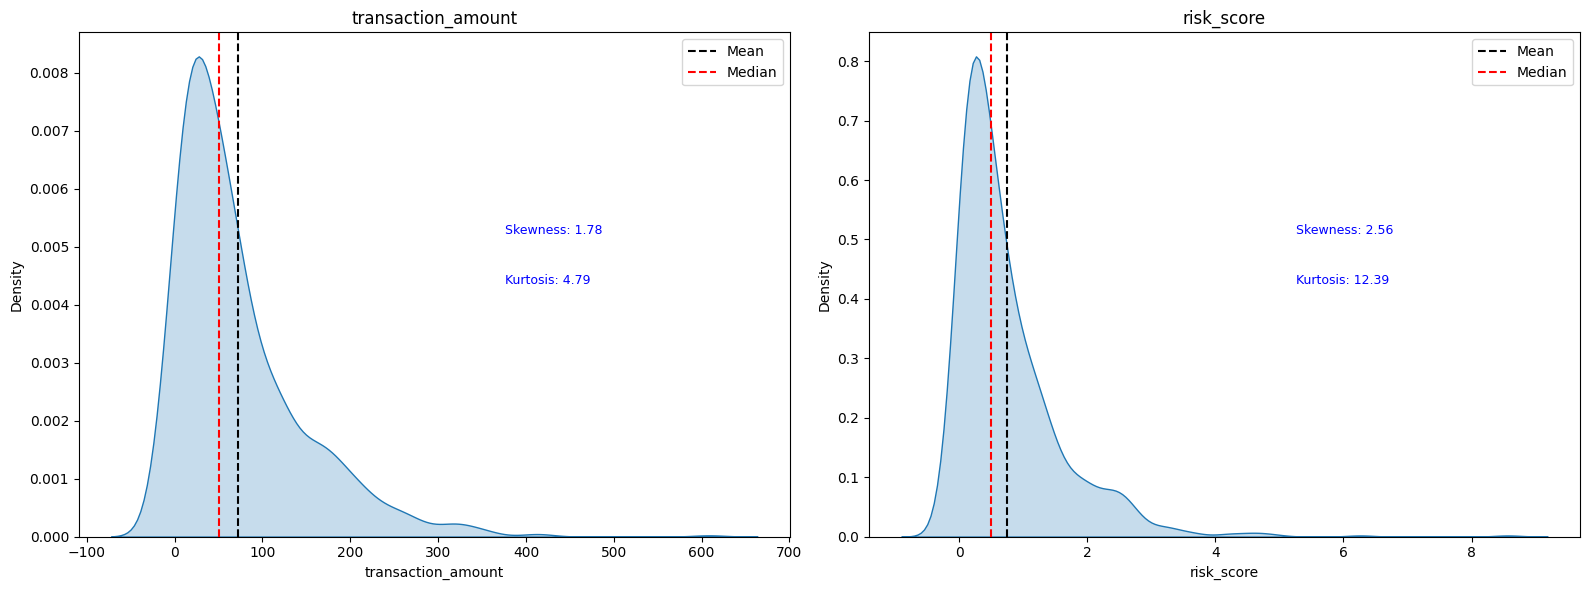

In [20]:
# Plot the kernel density estimates of numerical variables 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

for idx, col in enumerate(numerical_vars):
    ax = axes[idx]

    # KDE plot with mean and median lines
    sns.kdeplot(data=data, x=col, ax=ax, fill=True)
    stats = distrib_stats(data, col)

    # Add mean and median lines
    ax.axvline(x=stats['mean'], color='black', linestyle='--', label='Mean')
    ax.axvline(x=stats['median'], color='red', linestyle='--', label='Median')

    # Annotate skewness and kurtosis
    ax.text(0.6, 0.6, f"Skewness: {stats['skewness']:.2f}", transform=ax.transAxes, size=9, color='blue')
    ax.text(0.6, 0.5, f"Kurtosis: {stats['kurtosis']:.2f}", transform=ax.transAxes, size=9, color='blue')

    ax.legend()
    ax.set_title(f"{col}")

# Adjust layout
plt.tight_layout()
plt.show()


**Insights from KDE Plot of Numerical variablkes**

As previously mentioned, both distributions are highly skewed to the right. This is a common characteristic in financial and risk-related data, where most values are low, and there are a few (comparatively)extreme values.

* **Distribution Shape:** Both distributions are unimodal (has one peak) and highly skewed to the right. They are both concentrated at the lower end of the scale.
* **Central Tendency:** The **mean** (black dashed line) is greater than the **median** (red dashed line) for both distributions. This is a direct consequence of the positive skew i.e the mean is pulled to the right by the large transaction/risk score values, while the median remains a more robust measure of the center.
* **Skewness:** They both indicate strong positive skew. A value greater than 1 suggests a high degree of skewness.
 * **Kurtosis:** They are also both leptokurtic (positive kurtosis), indicating that the distribution has a more pronounced peak and heavier tails than a normal distribution. The extreme values in the right tail are making the tails "heavier."

In a practical context, these distributions suggest that:
* Most transactions are for small amounts.
* Most events or individuals have a low risk score.
* The rare instances of very large transactions or very high risk scores are extreme enough to heavily influence the average (mean) values. The median is a better measure of central tendency for both distributions.

##### **Multivariate Analysis**

**Relationship Between Numerical Features, and with target**

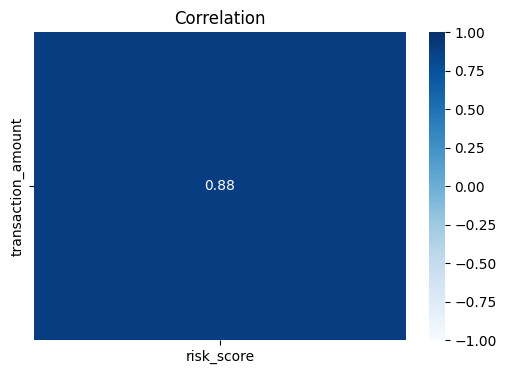

In [21]:
# Visualize correlation matrix
corr_value = data[numerical_vars].corr().iloc[0, 1]

plt.figure(figsize=(6, 4))
sns.heatmap([[corr_value]], annot=True, cmap="Blues", vmin=-1, vmax=1, cbar=True,
            xticklabels=[numerical_vars[1]], yticklabels=[numerical_vars[0]])

plt.title("Correlation")
plt.show()


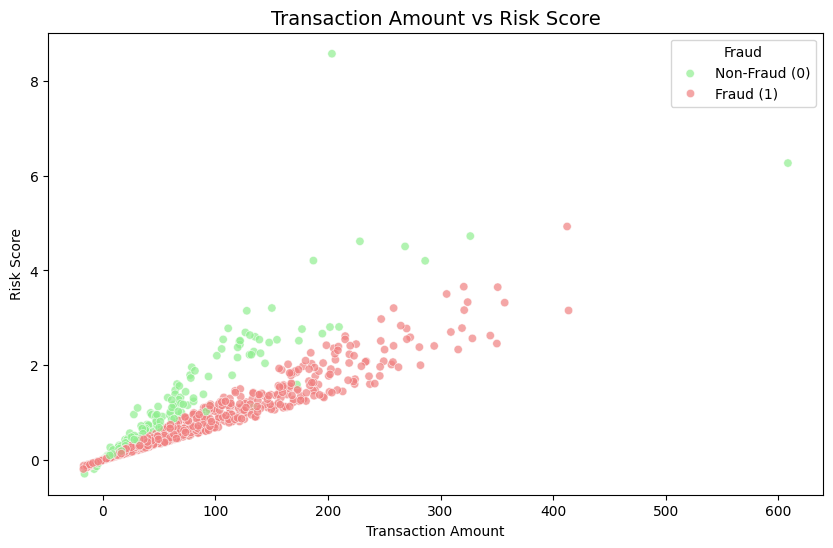

In [22]:
# Scatter plot of Transaction amount against risk score
plt.figure(figsize=(10, 6))
custom_palette = {1: "lightgreen", 0: "lightcoral"} # Define custom palette: 1 = non-fraud (light green), 0 = fraud (light red)
sns.scatterplot(
    data=data,
    x="transaction_amount",
    y="risk_score",
    hue="label_code",
    palette=custom_palette,
    alpha=0.7
)

plt.title("Transaction Amount vs Risk Score", fontsize=14)
plt.xlabel("Transaction Amount")
plt.ylabel("Risk Score")
plt.legend(title="Fraud", labels=["Non-Fraud (0)", "Fraud (1)"])
plt.show()


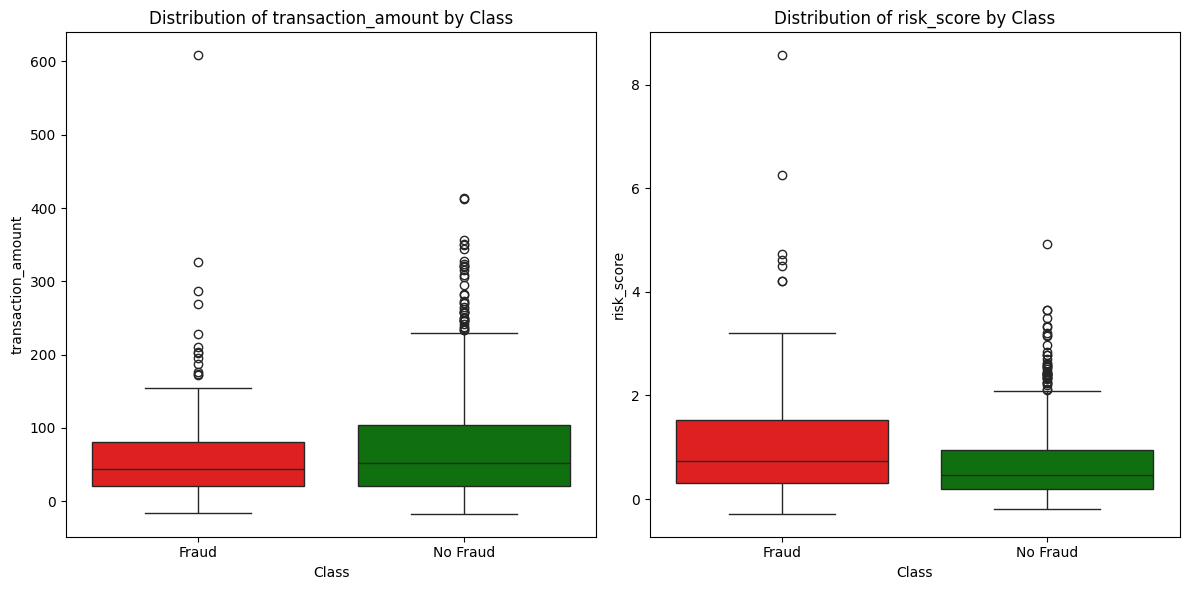

In [23]:
# Plot numerical feature distribution by class
n_rows, n_cols = 1, len(numerical_vars)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * len(numerical_vars), 6))

# Flatten the axes array to iterate over it 
axes = axes.flatten()

# Define custom colors
custom_palette = {"No Fraud": "green", "Fraud": "red"}

# Loop through numerical columns and create boxplots
for i, col in enumerate(numerical_vars):
    sns.boxplot(
        data=data, 
        x="Label", 
        y=col, 
        ax=axes[i], 
        palette=custom_palette
    )
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel(col)
    axes[i].set_title(f"Distribution of {col} by Class")

plt.tight_layout()
plt.show()


**Insights on Relationship Between Transaction Amount and Risk Score**

* **Strong, Positive linear Relationship:** The scatter plot shows a clear linear relationship i.e Higher **transaction amount** carry higher **risk score**. This makes sense. A very high transaction amount is a strong indicator of potential fraud, and so it should lead to a higher risk score.
* **Presence of High-Risk Outliers:** The scatter plot reveals a sparse number of points in the top-right quadrant, where both the transaction amount and risk score are very high. These are likely the fraudulent transactions your model is trying to detect. The fact that they are clustered in this area validates the idea that high-value transactions are often associated with high risk.
* **Correlation:** The correlation value of **0.88** confirms a **strong positive correlation** between the two variables. It quantifies the relationship we see in the scatter plot.
* **Risk-Score and Fraud Relationship:** The trend of Non Fraud transactions seems to be less steeper than those of fraudulent transactions and the boxplot show they genrally have lower values comapred to fraudulent transaction. i.e Non Fraud transactions have a relatively lower risk score for high transaction than for fraudulent transaction of the same amount. This indicates that the risk score could be a great indicator of fraudulent transactions.

---

**Possible Implications for Modelling**

The strong positive correlation between `transaction_amount` and `risk_score` presents a classic machine learning issue: **multicollinearity**.

* **Redundancy:** Since the two variables are so closely related, they are essentially providing a lot of the same information to the model. In a fraud detection context, if a large transaction amount is already a strong predictor of fraud, and the risk score is already designed to capture this, including both in a simple model could be redundant.
* **Model Instability:** For linear models like Linear or Logistic Regression, multicollinearity can make the model's coefficients unstable and difficult to interpret. Small changes in the data can lead to large, illogical changes in the coefficients, which makes it hard to understand which feature is truly driving the prediction. This can also reduce the model's generalization performance on new, unseen data.
* **Diminished Returns:** Including both variables might not significantly improve the model's predictive power over using just one of them. For linear models, we might be adding complexity without adding much value.

---

**Mitigation Strategies**

To mitigate this effect for our model, we would do the following.
* **Model Choice:**
    * **Tree-based Models:** Tree-based models like **Gradient Boosting** are generally less affected by multicollinearity. They work by making decisions based on individual features and if two features are highly correlated, a tree will select the one that provides the best split at a particular node and use it to partition the data. This process effectively handles the redundancy without the instability seen in linear models. This is often why these models are a popular choice for fraud detection problems. This is helpful for us, as we wouldn't need to drop features from our already limited dataset.
* **Feature Selection:**
    * **Feature Engineering:** Combine either of the variables (transaction amount inour case) with other variables to form a new interaction term. 

* **Use Regularization:**
    * Since we plan to use **Tree-based Models**, we would limit the depth of trees (use shallow trees) to mitigate any possible overfitting and multicollinearity issues.

#### **Categorical Variables**

##### **Univariate Analysis**

**Category Distribution**

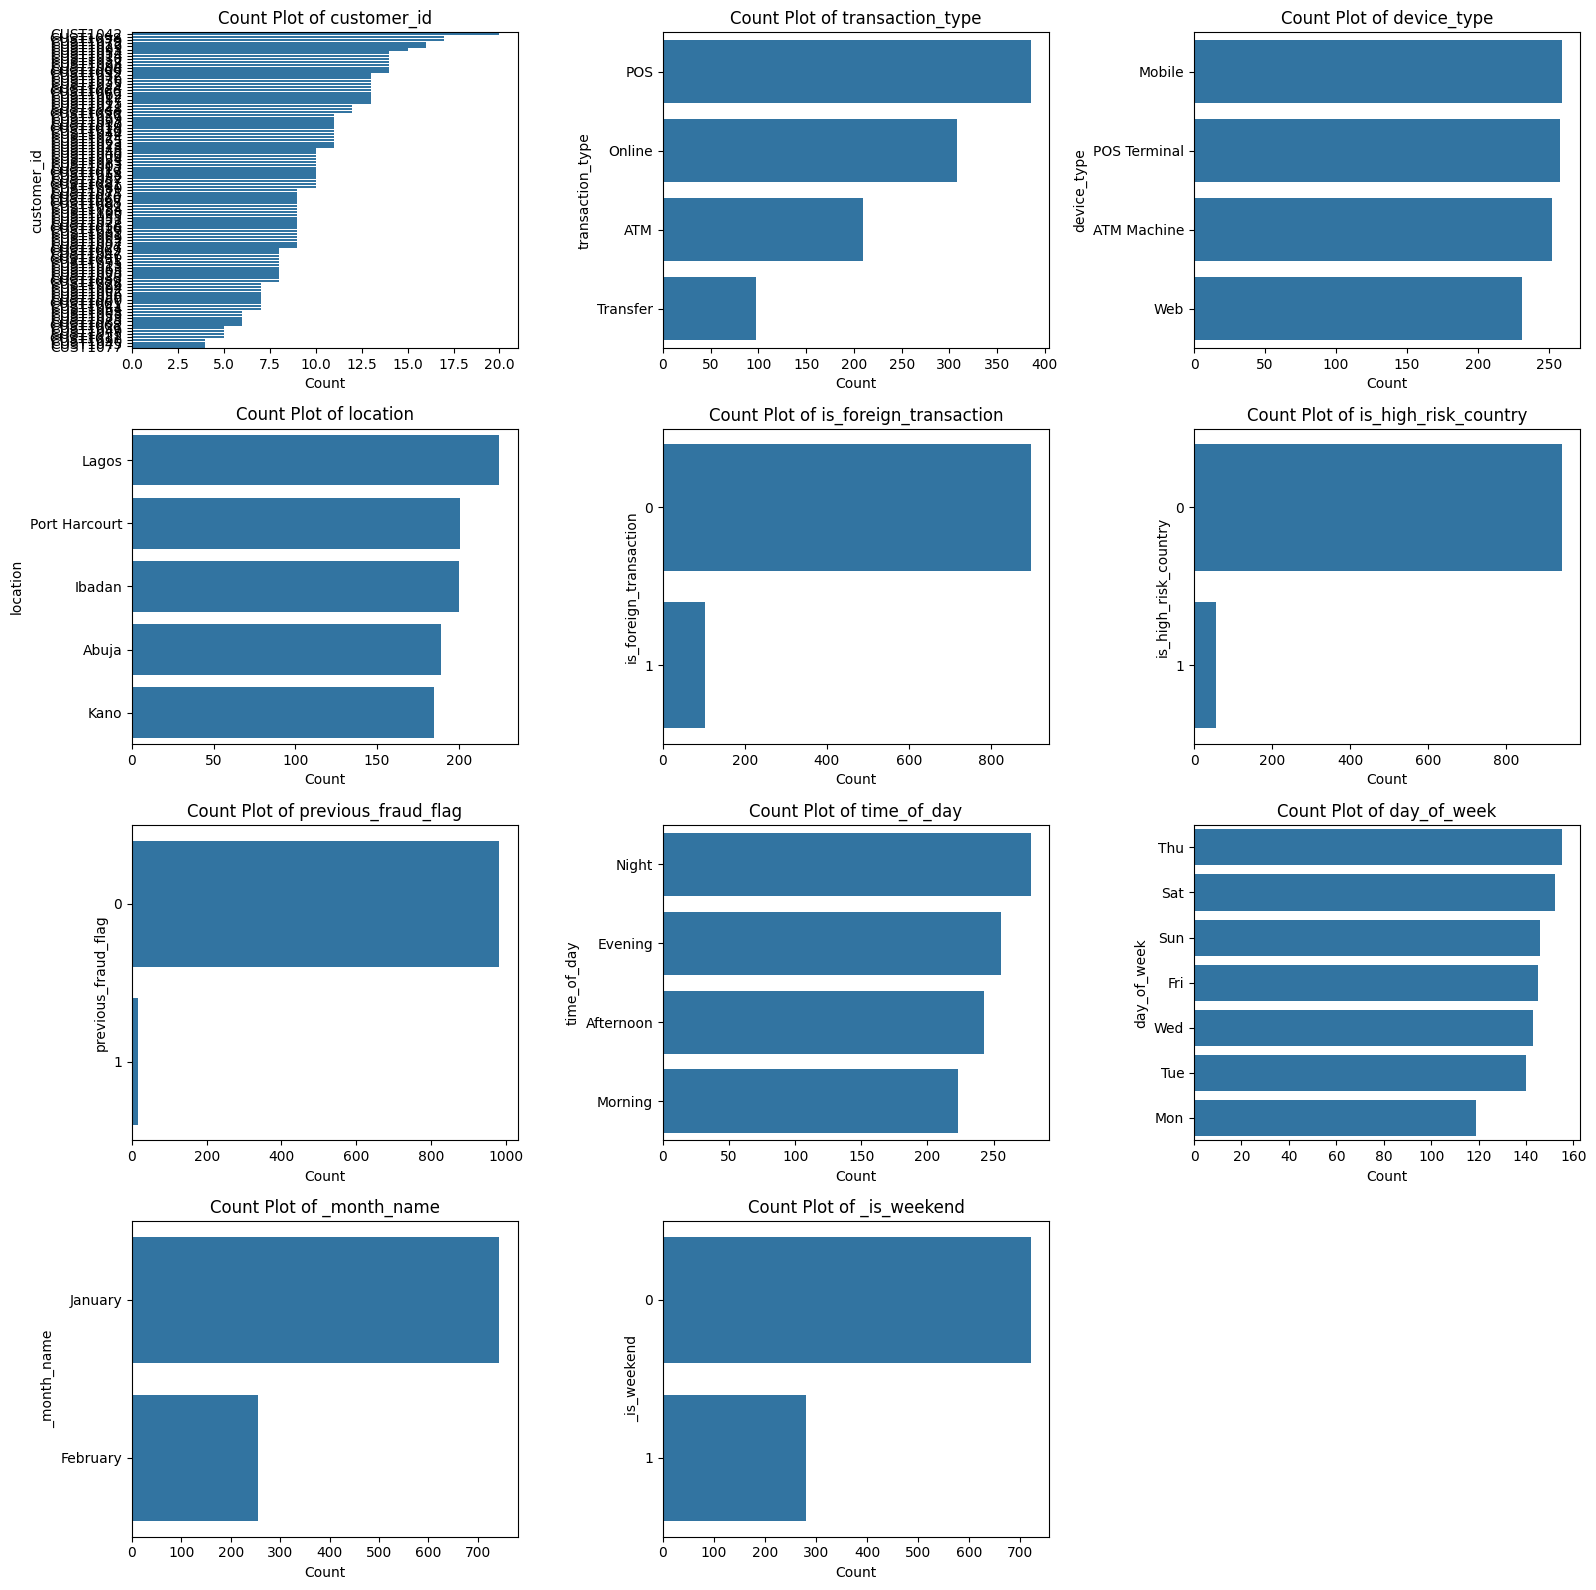

In [24]:
# Count Plot of categorical feature distribution 
n_rows, n_cols = 4, 3  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16))  
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    
    category_count = data[var].value_counts()
    sns.countplot(y=data[var], order=category_count.index, ax=axes[i])
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(var)
    axes[i].set_title(f"Count Plot of {var}")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Insights from Categorical Data Univariate Analysis**

* **`transaction_type` & `device_type`:** Most transactions are made via **"POS"** and are of the **"online"** type. The use of device is almsot even (i.e no clear preference for customer base)
* **`is_foreign_transaction` & `is_high_risk_country`:** The vast majority of transactions are **domestic** and do not originate from a high-risk country. This is a crucial finding because it means that fraudulent activity, which is a minority class, might be concentrated in these smaller, higher-risk or foreign categories.
* **`previous_fraud_flag`:** Almost all transactions are from customers with no prior fraud history. This is a clear indicator of the **class imbalance** problem. The few instances where `previous_fraud_flag` is 1 are valuable and likely highly predictive of future fraud.
* **`time_of_day`, `day_of_week`, `month_name`:** The transaction volumes are fairly evenly distributed across different times of the day and days of the week, with a slight dip on **Mondays**. This lack of a strong temporal pattern suggests that fraud is not heavily concentrated at a specific time of day or on a specific day of the week, but a more detailed analysis would be needed to be certain. There is a significant difference in transaction volume between the two months shown. This is most probably because we only have 2 weeks worth of data in February.
* **`is_weekend`:** A fair amount ofthe transaction happen on weekdays.
* **`location`:** Transactions are distributed across multiple locations, with Lagos, Port Harcourt, and Ibadan being the most common.
* **`customer_id`:** We have between 4 to 20 transactions per customer in that time. This might be limited in providing long term customer behaviour for our model.

---

**Implications for our Fraud Detection Model**

* **Feature Engineering:** The categorical data provides great opportunities for feature engineering.  We would create new features that capture the risk associated with less common categories. 
* **Class Imbalance:** The plots for `is_foreign_transaction`, `is_high_risk_country`, and `previous_fraud_flag` all highlight severe class imbalance. Our model will see very few examples of transactions from high-risk countries or from customers with a fraud history. We need to handle this properly, or else the model will not learn to recognize these crucial fraud indicators.
* **Feature Importance:** Features like `is_high_risk_country`, `is_foreign_transaction`, and `previous_fraud_flag` are likely to be **highly important** for your model, even though they represent a small portion of the data. They act as strong signals that immediately increase the likelihood of fraud.

Next, we would consider the relationships between these variables (if they provide similar information for our data) and their relationship to the target variable (if there are enough variance between fraud and non fraud transactions in each of our categorical variables, to see if these labels are more related to a catgorical variable type)

#### **3.3.2 Multivariate Analysis**

The Cramér’s V statistic is used to quantify the strength of association between the categorical variables, and label. Think of it as the correlation value, but for categorical variables. Its values range from 0 (no association) to 1 (perfect association), making it a useful way to see how strongly categories are related without assuming any direction of causality.

It works by first performing a chi-square test of independence on a contingency table, then normalizing the chi-square statistic by the sample size and table dimensions. This correction ensures the score is comparable across different variable pairs, regardless of their number of categories.

In practice:

Close to 0 → little or no relationship.

Moderate values (~0.3–0.5) → meaningful but not perfect association.

Closer to 1 → strong association, categories are highly dependent.

We use Cramér’s V here to evaluate relationships both between categorical features (to spot redundancy or collinearity) and between categorical features and the fraud label, to understand which categories carry the strongest fraud signals.

In [25]:
# Function to compute Cramér's V statistic
def cramers_v(x, y):
    """
    Compute Cramér's V statistic for categorical-categorical association.
    
    Parameters
    ----------
    x : array-like or pd.Series
        First categorical variable.
    y : array-like or pd.Series
        Second categorical variable.
    
    Returns
    -------
    float
        Cramér's V value (0–1), or np.nan if not computable.
    """
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
        return np.nan  # Not enough categories to compute correlation

    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # Bias correction
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1)) if n > 1 else 0
    rcorr = r - ((r-1)**2) / (n-1) if n > 1 else 1
    kcorr = k - ((k-1)**2) / (n-1) if n > 1 else 1

    denominator = min((kcorr - 1), (rcorr - 1))
    if denominator <= 0:
        return np.nan

    return np.sqrt(phi2corr / denominator)

**Categorical Feature Correlation Matrix**

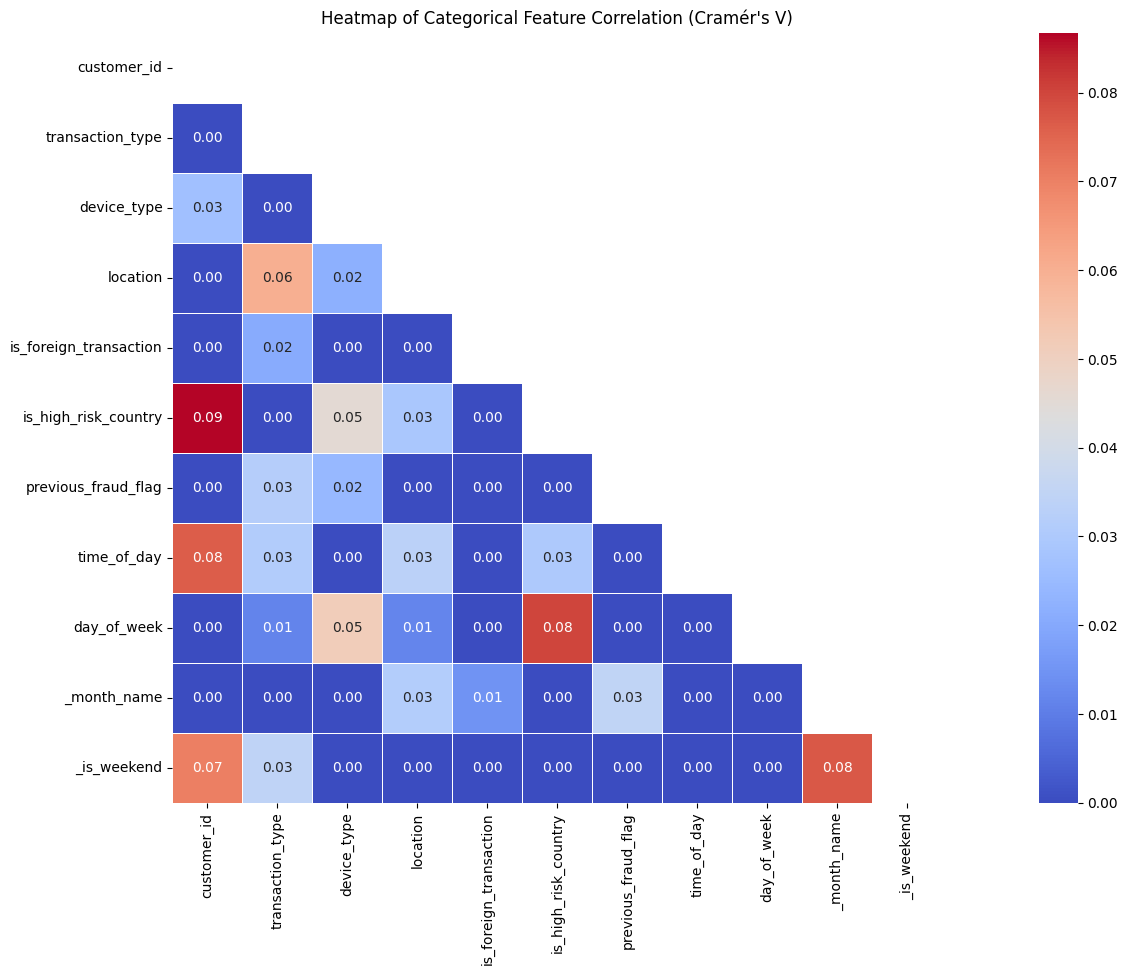

In [26]:
# Categorical feature correlation matrix
corr_matrix = pd.DataFrame(
    np.zeros((len(categorical_vars), len(categorical_vars))),
    index=categorical_vars,
    columns=categorical_vars
)

for col1 in categorical_vars:
    for col2 in categorical_vars:
        if col1 != col2:
            corr_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot
plt.figure(figsize=(25, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Heatmap of Categorical Feature Correlation (Cramér's V)")
plt.show()

**Insights from categorical Correlation Matrix**
The plot shows no clear associations between the categorical variables. This means that the categorical variables that show decent direct relationships could be added to our model with no concerns for **Multicollinearity** issue.

**Categorical feature vs Target relationship**

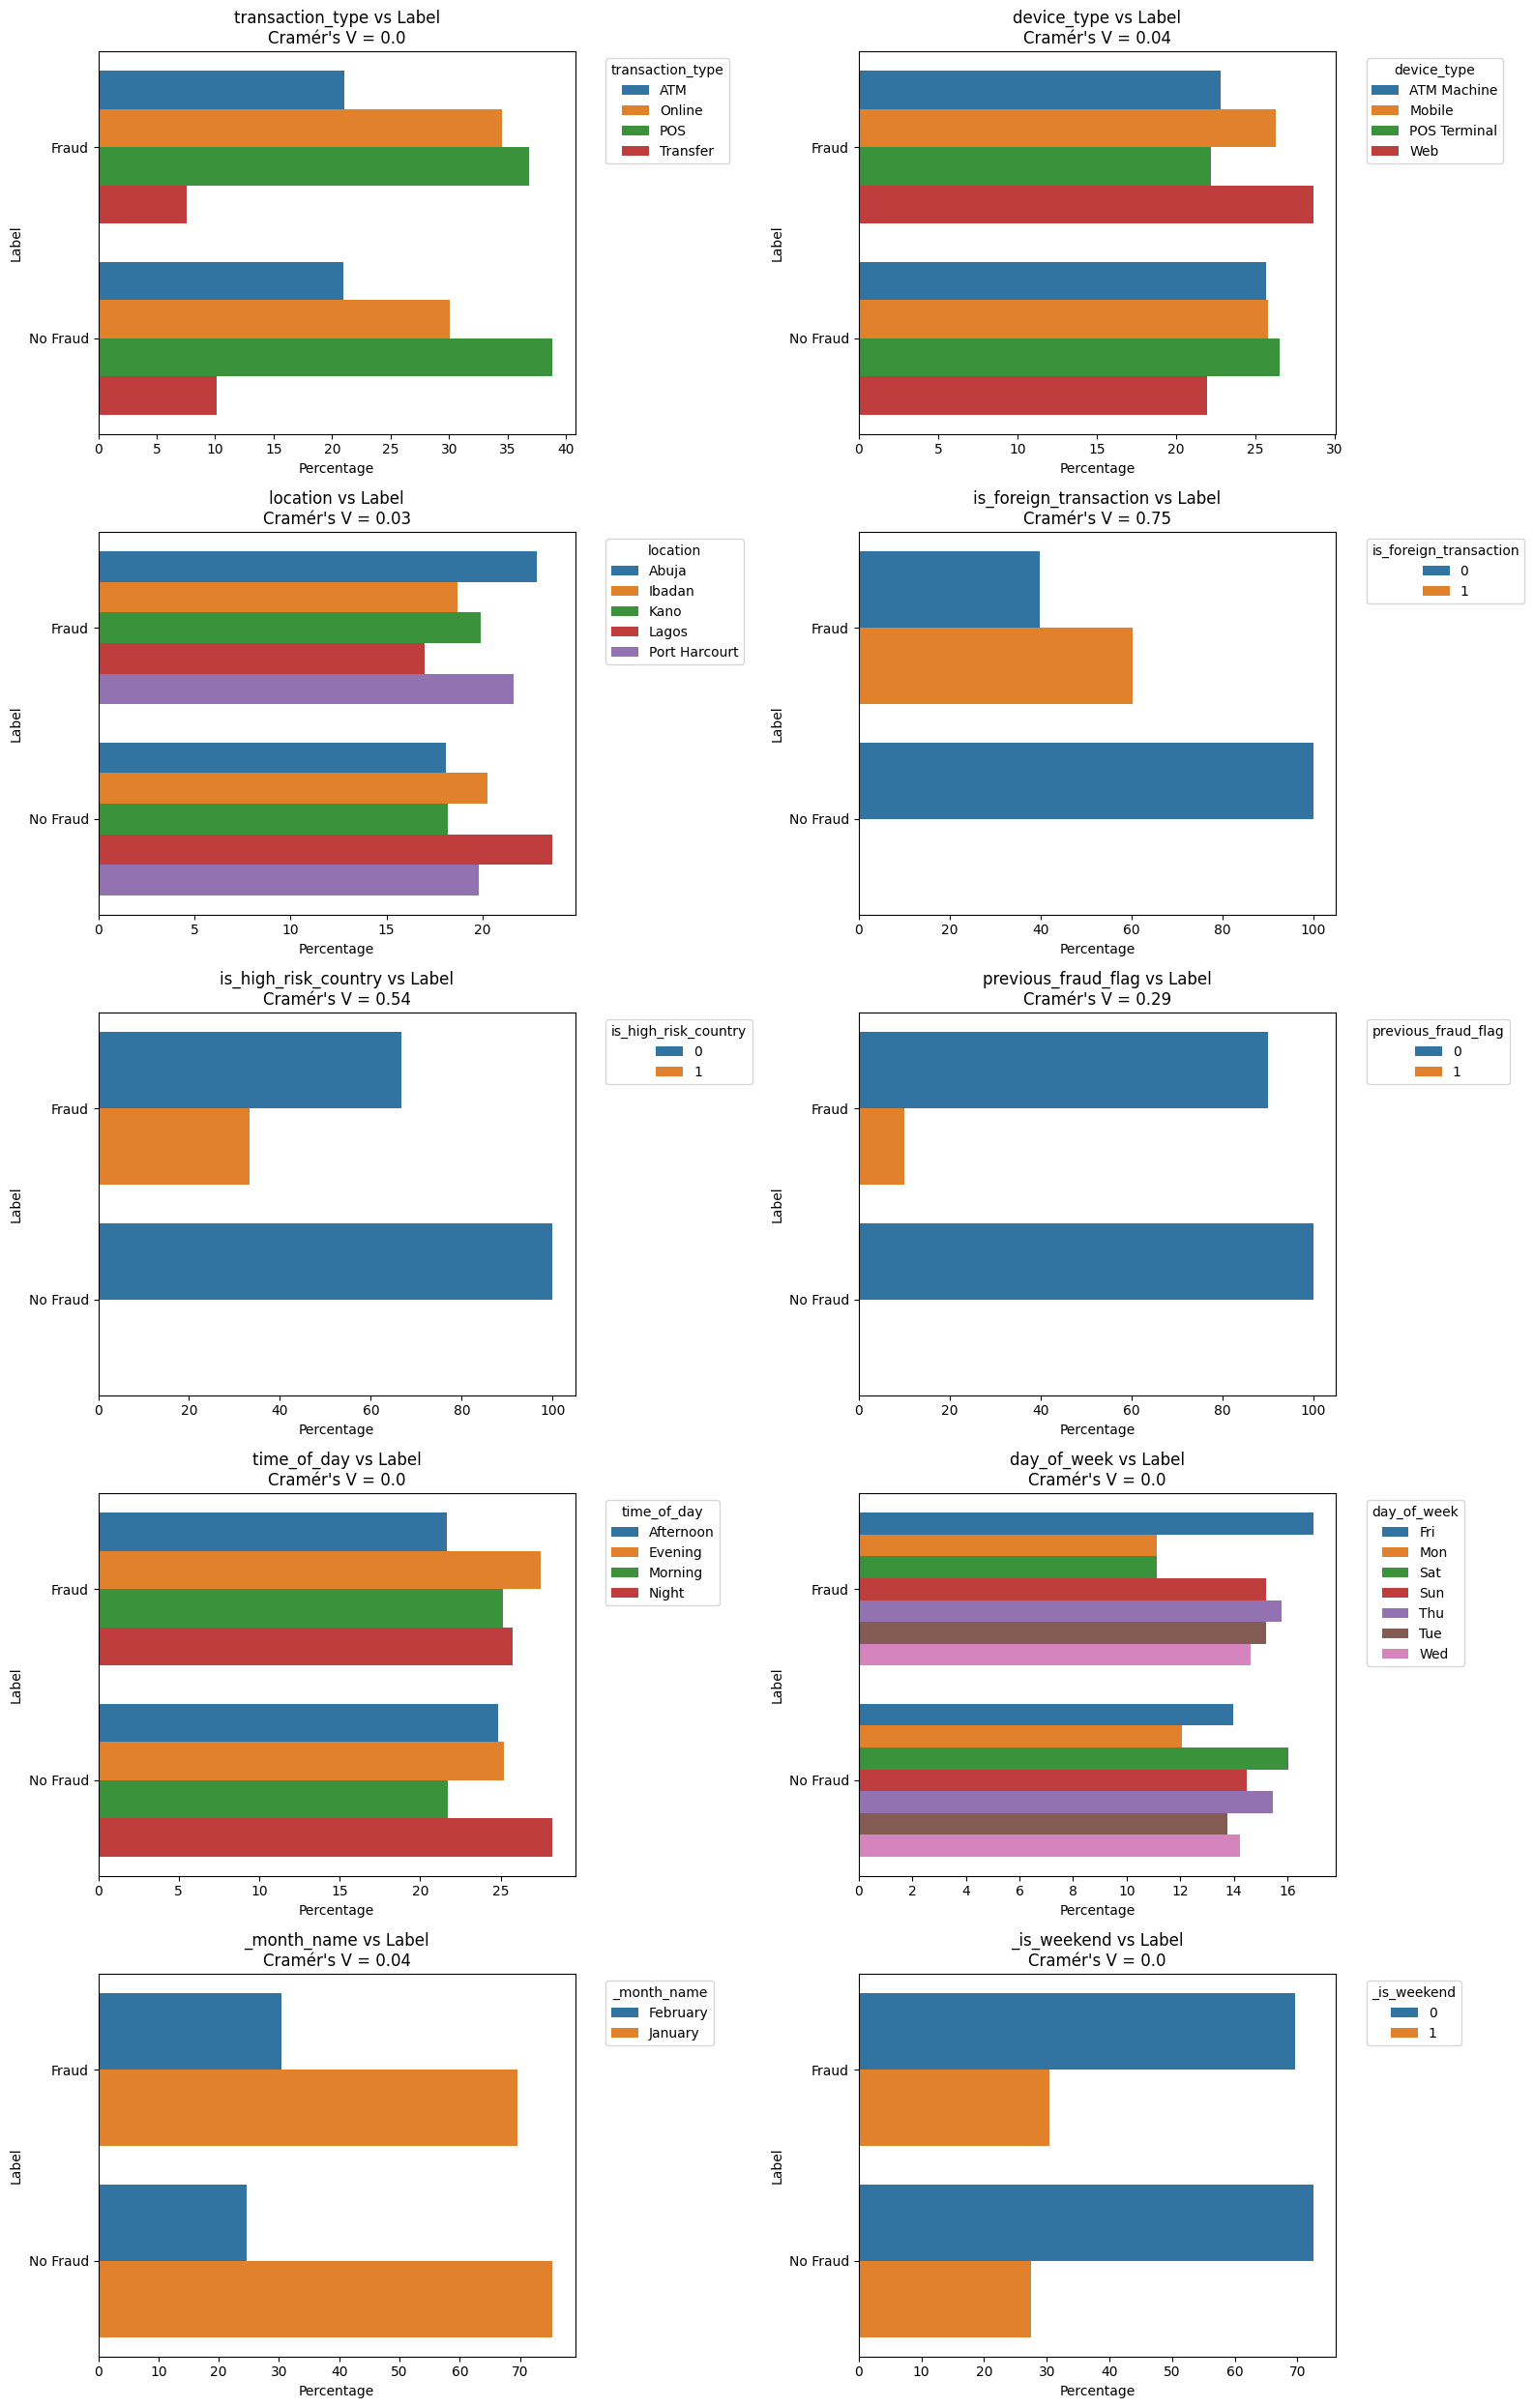

In [27]:
# Categorical feature vs Target relationship
n_features = len(categorical_vars[1:])
ncols = 2
nrows = (n_features + ncols - 1) // ncols  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5*nrows))
axes = axes.flatten()

for i, feature in enumerate(categorical_vars[1:]):
    cramers_value = cramers_v(data[feature], data['Label'])

    contingency_table = pd.crosstab(data[feature], data['Label'])
    contingency_table_percent = (
        contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100
    ).reset_index()

    df_stacked = contingency_table_percent.melt(
        id_vars=[feature], var_name="Label", value_name="percentage"
    )

    ax = axes[i]
    sns.barplot(data=df_stacked, y="Label", x="percentage", hue=feature, ax=ax)

    ax.set_title(f"{feature} vs Label\nCramér's V = {round(cramers_value, 2)}")
    ax.set_xlabel("Percentage")
    ax.set_ylabel("Label")
    ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc="upper left")

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Insights from Categorical Feature-Label Plots**

* **`is_high_risk_country` and `is_foreign_transaction` are strong predictors of fraud.** These two features show the most significant difference between the fraud and non-fraud groups. While only a small percentage of overall transactions are foreign or from a high-risk country, a disproportionately high percentage of fraudulent transactions fall into these categories. This indicates they're very strong signals for identifying fraud.
* **`previous_fraud_flag` is another useful predictor.** The plot for this feature shows that a small fraction of transactions have a `previous_fraud_flag` of 1, but this category makes up a substantial portion of the fraudulent transactions. This feature is likely important for our model.
* **Temporal features are weak predictors of fraud.** The plots and Cramer's V value for `time_of_day`, `day_of_week`, `month_name`, and `is_weekend` show very similar distributions for both fraudulent and non-fraudulent transactions. This means that fraud doesn't appear to be concentrated on a specific day, time, or month. These features are likely less important for your model's predictive power compared to others.
* **Location, Transaction Type and Device Type show limited predictive power.** The distribution of fraud and non-fraud transactions across locations and device types seems identical. Although, fraud transactions seem to have a higher percentage of "Web" and "Mobile" device types compared to non-fraud transactions. Our model can likely use these subtle differences to improve its predictions.

**Implications for our Model**

* **Feature Importance:** Our fraud detection model will likely assign the high importance to **`is_high_risk_country`**, **`is_foreign_transaction`**, and **`previous_fraud_flag`**. These features have a very clear and powerful relationship with the fraud label.
* **Feature Selection:** Given the weak relationship with the fraud label, the temporal features should be dropped as they carry redundantinformation for our the model. 
* **Feature Engineering:** Device type, location and transaction types could become useful if properly engineered.

**Likelihood of Fraud per Customer**

In [28]:
# Group by customer_id and calculate fraud percentage per customer
fraud_table = (
    data.groupby("customer_id")[target_var]
    .mean()  # mean of 0/1 gives fraud rate
    .reset_index()
)

# Convert to percentage
fraud_table["%Fraud"] = fraud_table[target_var] * 100

# Drop the original target column
fraud_table = fraud_table.drop(columns=[target_var])

# Sort by %Fraud (descending) and show top 10
top_fraud_customers = fraud_table.sort_values("%Fraud", ascending=False).head(10)

top_fraud_customers

,customer_id,%Fraud
8,CUST1008,66.67
33,CUST1033,62.50
53,CUST1053,50.00
73,CUST1073,50.00
92,CUST1092,44.44
0,CUST1000,40.00
12,CUST1012,38.46
46,CUST1046,37.50
70,CUST1070,36.36
6,CUST1006,35.71


**Insights**
The customers listed above are flagged as being highly likely to commit fraud. Therefore there is a clear relationship between customer profiles and fraud. We would engineer features that incoperate customer behaviours for our model.

#### **Temporal Variable**

We would be using the average (not total) transaction count per temporal variables. This is to mitigate the effect of not having a complete cycle of data per month

In [29]:
# Plot transaction trend over time
def plot_transaction_trend(data, col, by_label=False, average=True, figsize=(8, 5)):
    """
    Plot transaction counts for a given column.
    Can plot overall or split by label_code.
    Optionally plot average count per unit instead of total counts.

    Parameters
    ----------
    data : pd.DataFrame
        Transaction data.
    col : str
        Column name to group/plot.
    by_label : bool, default=False
        If True, split plots by label_code (e.g., fraud vs non-fraud).
    average : bool, default=False
        If True, plot average counts instead of total counts.
    figsize : tuple, default=(8, 5)
        Figure size.
    """
    # --- 1. Handle datetime vs categorical/numeric
    if np.issubdtype(data[col].dtype, np.datetime64):
        if by_label:
            trend = (
                data.groupby([data[col].dt.date, "label_code"])
                    .size()
                    .reset_index(name="count")
            )
            group_cols = ["label_code"]
            xcol = col
        else:
            trend = (
                data.groupby(data[col].dt.date)
                    .size()
                    .reset_index(name="count")
            )
            group_cols = []
            xcol = col
    else:
        if by_label:
            trend = (
                data.groupby([col, "label_code"])
                    .size()
                    .reset_index(name="count")
            )
            group_cols = ["label_code"]
            xcol = col
        else:
            trend = (
                data[col].value_counts()
                    .sort_index()
                    .reset_index()
            )
            trend.columns = [col, "count"]
            group_cols = []
            xcol = col

    # --- 2. Convert to average if requested
    if average:
        denom = trend[xcol].nunique()  # number of unique periods
        trend["count"] = trend["count"] / denom

    # --- 3. Labels & Titles
    clean_name = col.strip("_").replace("_", " ").title()
    if by_label:
        title = f"Average Transactions by {clean_name} (Fraud vs Non-Fraud)" if average \
                else f"Transaction Count by {clean_name} (Fraud vs Non-Fraud)"
    else:
        title = f"Average Transactions by {clean_name}" if average \
                else f"Transaction Count by {clean_name}"
    xlabel = clean_name

    # --- 4. Plot
    plt.figure(figsize=figsize)
    if by_label:
        sns.lineplot(data=trend, x=xcol, y="count", hue="label_code", marker="o")
        plt.legend(title="Fraud", labels=["Non-Fraud (0)", "Fraud (1)"])
    else:
        sns.lineplot(data=trend, x=xcol, y="count", marker="o")

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Average Transactions" if average else "Transactions")
    plt.tight_layout()
    plt.show()


##### **Univariate Trend Analysis**

**Daily and Hourly Transaction Trend**

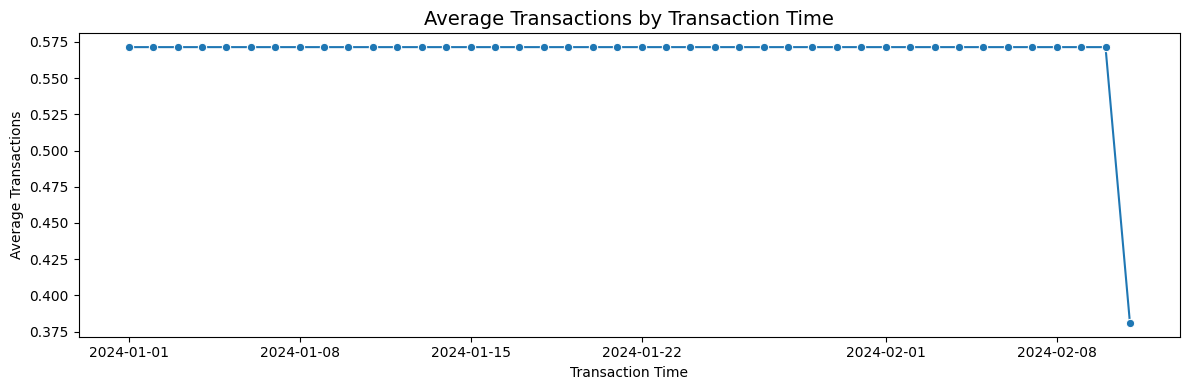

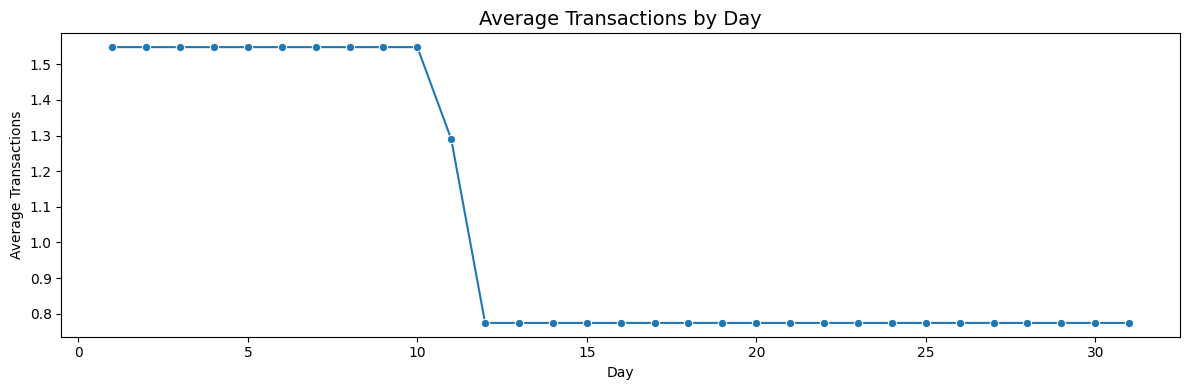

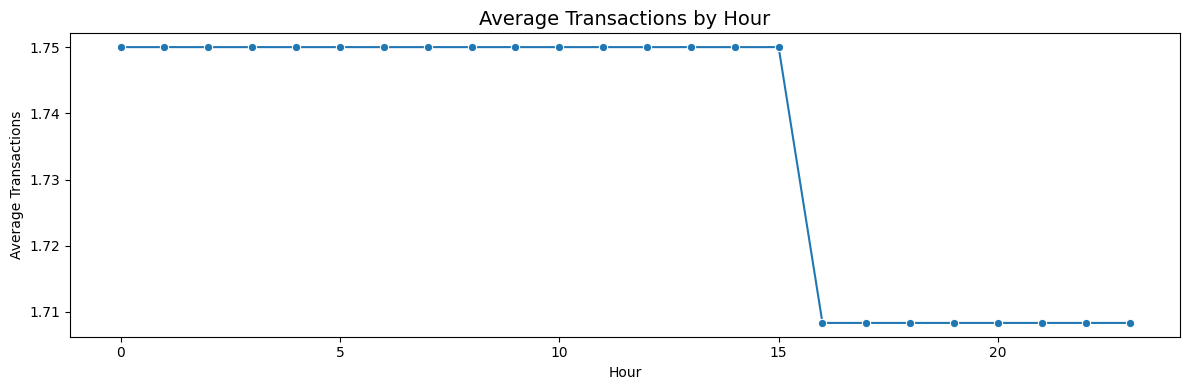

In [30]:
for col in ["transaction_time", "_day", "_hour"]:
    plot_transaction_trend(data, col, by_label=False, figsize=(12, 4))

**Insights Daily and Horly Transaction Trend (count) Plot**

* **Consistent Average across the months:** For the entire month of January and the first week of February, the average number of transactions per day remains constant. This indicates a consistent and predictable level of activity during this time the sudden drop around February 8th indicates the last day ofthe collation (incomplete).
* **Much more transactions onthe first week:** There are almost twice as more transactions on the first week ofthe month,as compared to the rest of the month. This could be indicative of salaried employees, have a burst of spending at this time as they pay bills, make planned purchases, or engage in discretionary spending. This insight can be useful for operational readiness (for that surge)and targeting marketing promotions.

#### **Multivariate Trend Analysis**

**Trend of Fraud vs Non Fraud activatives**

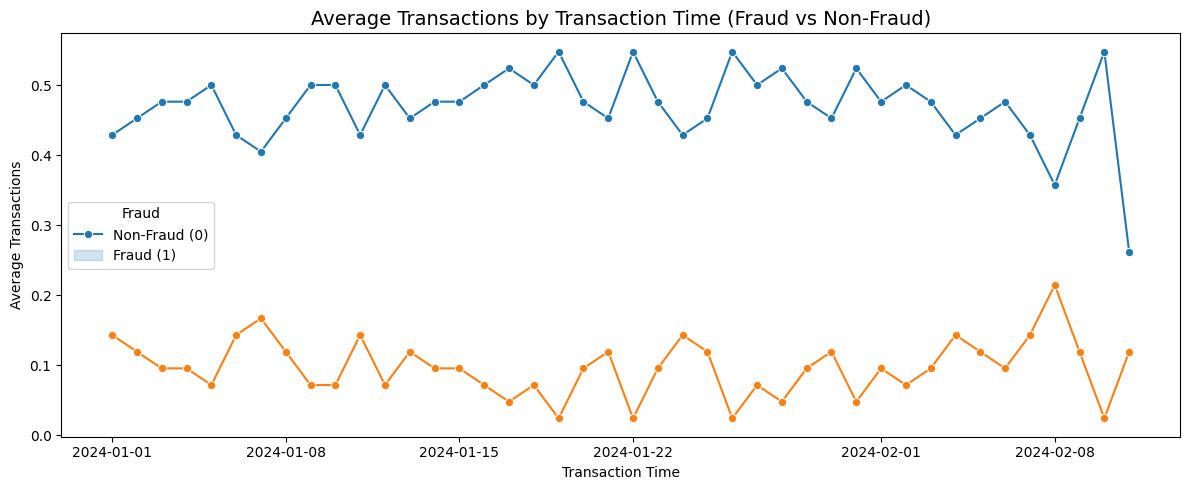

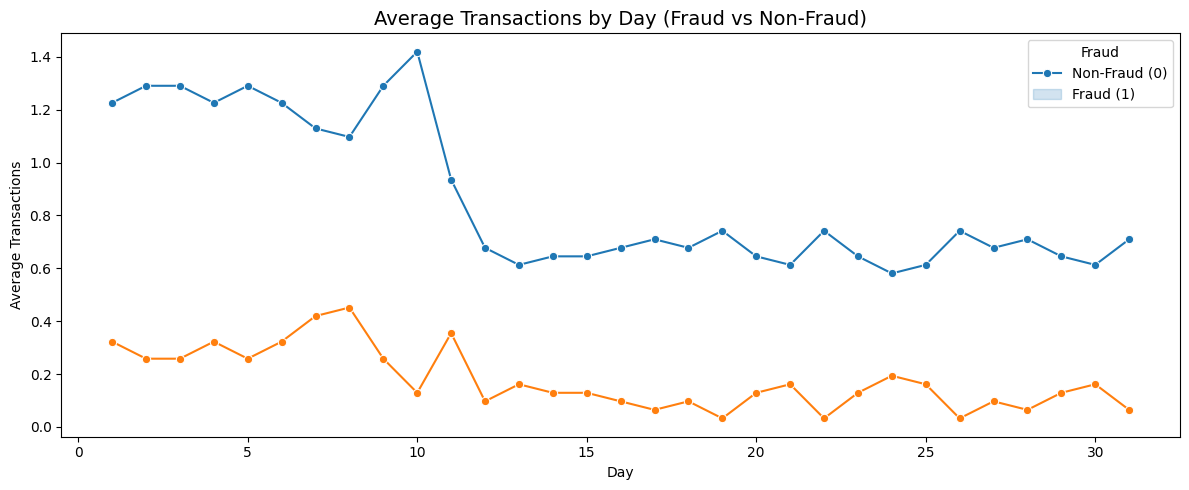

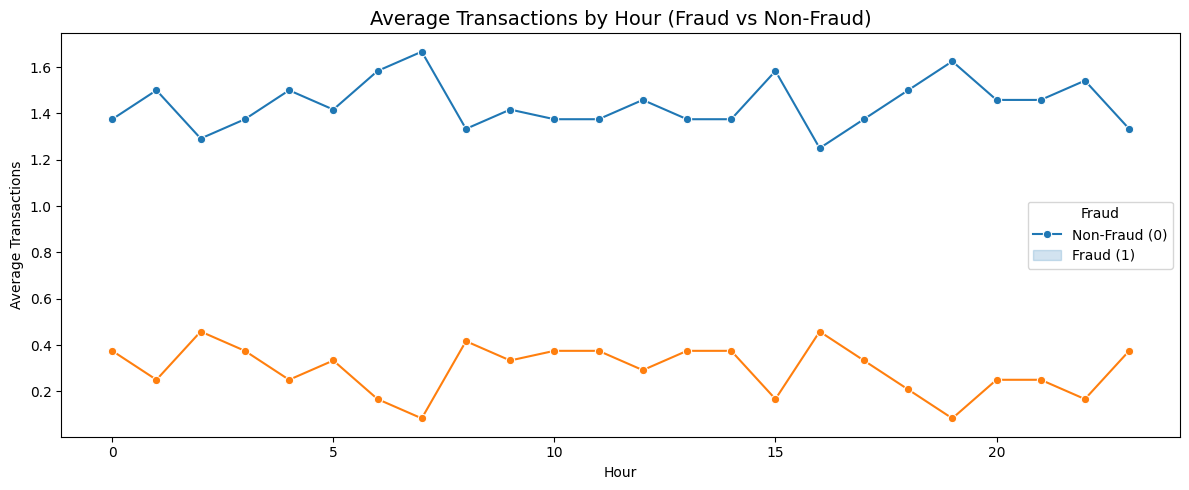

In [31]:
for col in ["transaction_time", "_day", "_hour"]:
    plot_transaction_trend(data, col, by_label=True, figsize=(12, 5))

**Insights from Transaction Trend Per Fraud Label Plot**

* **Overall Transaction Trend:**  The average number of non-fraud transactions (the blue line) is consistently much higher than fraudulent transactions (could be as a result of data imbalance). However, both trends maintains a stable average over the period.

* **Fraud Trend by Hour of Day and Day of Week:** Looking at the plots in "Categorical features vs Label," the distributions of fraud and non-fraud transactions across different times of the day and days of the week are **very similar.

This is a key insight because it means a model cannot simply rely on temporal features alone to predict fraud.

**Summary of EDA**

The most distinctive differences in fraud trends are not temporal but are linked to the nature of the transaction itself. The plots for `is_foreign_transaction`, `is_high_risk_country`, and `previous_fraud_flag` clearly show that fraud is not a random occurrence while the `risk_score` and `transaction_amount` also have considerable relationship with fraudulent transactions.

**What This Means for the Model**

* **High Predictive Power:** The model will find `risk_score`, `transaction_amount`, `is_foreign_transaction`, `is_high_risk_country`, `previous_fraud_flag` to be the most relevant and important features. 
* **Weak Predictive Power:** The model will likely give temporal features very little importance. These features provide little to no discriminative power for distinguishing between fraud and non-fraud.
* **Feature Engineering:** `device`, `transaction_type` and `location` could provide useful contribution to the model if well engineered.

### **Feature Engineering**

For our feature engineering step, we enrich the dataset by creating features that capture **transactional dynamics, temporal behavior, and sudden switches in customer activity or behaviour**. These features highlight signals that may distinguish fraud from legitimate activity.

The engineered features include:

* **Transaction Amount Transformations**:

  * Removal of negative amounts (likely errors or refunds).
  * Log transformation of transaction amounts to reduce skewness and dampen the effect of extreme outliers.

* **Relative Transaction Behavior**:

  * `past_mean_amount`: Measures how a customer’s current transaction amount compares to their historical *non-fraud* average. Large deviations from typical spending patterns may signal fraud.

* **Recency Patterns**:

  * `recency_ratio`: Captures how quickly a customer is transacting relative to their historical pace. A sudden burst of transactions in a short time window can be a red flag for fraud.

* **Behavioral Switch Risks**:

  * `geo_switch_risk`: Identifies sudden changes in transaction location compared to the most recent non-fraud transaction and considers how quickly this change occurred.
  * `device_switch_risk`: Flags rapid changes in device type (e.g., moving from a POS terminal to a mobile device within minutes).
  * `transaction_type_switch`: Tracks abrupt switches in transaction type (e.g., from online to ATM).
  * These “switch” features are designed to capture **inconsistencies in customer behavior**  such as using different devices or locations within suspiciously short timeframes — which often indicate fraudulent activity.

By integrating these features, we aim to capture **both absolute signals** (like unusually high transaction amounts) and **relative, contextual signals** (like abnormal speed, location changes, or behavioral switches). 

In [32]:
# Sort data by transaction time
data = data.sort_values(by="transaction_time")

#### **Transaction Amount**

**Remove Negative Amounts**

In [33]:
# Remove rows with negative transaction amounts
data = data[data["transaction_amount"] >= 0]

**Log Transformed Amount**

In [34]:
# Log-transformed amount
data["log_transaction_amount"] = np.log1p(data["transaction_amount"])

**Transaction Amount Relative to Past (Mean)**

In [35]:
def compute_amount_relative_to_history_nonfraud(
    data, 
    user_col="customer_id",
    time_col="transaction_time",
    amount_col="transaction_amount",
    label_col="label_code"
):
    """
    Computes transaction_amount / past_mean(non-fraud only) for each row.
    The past mean uses only non-fraud transactions from the same user that 
    occurred before the current transaction_time.
    """
    # Make a working copy sorted per user and time
    df = data[[user_col, time_col, amount_col, label_col]].copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df_sorted = df.sort_values([user_col, time_col])

    # For each user, compute expanding mean using only non-fraud txns
    def per_user(group):
        mask = group[label_col] == 0
        past_mean = group.loc[mask, amount_col].expanding().mean().shift()
        past_mean = past_mean.reindex(group.index)
        # fallback: if NaN (first txn or no past non-fraud), use own amount
        return past_mean.fillna(group[amount_col])

    past_mean_series = df_sorted.groupby(user_col, group_keys=False).apply(per_user)

    # Reindex to original data order
    past_mean_amount= past_mean_series.reindex(data.index)

    # # Compute ratio
    # ratio = data[amount_col] / past_mean_amount

    return past_mean_amount


data["past_mean_amount"] = compute_amount_relative_to_history_nonfraud(
    data,
    user_col="customer_id",
    time_col="transaction_time",
    amount_col="transaction_amount",
    label_col="label_code"
)

#### **Transaction Recency**

In [36]:
def compute_recency_ratio(
    df, customer_col="customer_id", time_col="transaction_time", label_col="label_code"
):
    temp = df.copy()
    temp[time_col] = pd.to_datetime(temp[time_col], errors="coerce")
    temp = temp.sort_values(by=[customer_col, time_col]).copy()
    
    # Time since last txn
    temp["time_diff_min"] = (
        temp.groupby(customer_col)[time_col]
            .diff()
            .dt.total_seconds() / 60
    )
    
    # Historical avg time gap (non-fraud only)
    temp["avg_time_nonfraud"] = (
        temp.assign(nonfraud_time_diff=temp.where(temp[label_col]==0)["time_diff_min"])
            .groupby(customer_col)["nonfraud_time_diff"]
            .expanding()
            .mean()
            .reset_index(level=0, drop=True)
    )
    
    # Rolling avg of last 3 gaps
    temp["rolling3_time"] = (
        temp.groupby(customer_col)["time_diff_min"]
            .transform(lambda x: x.rolling(3, min_periods=1).mean())
    )
    
    # Compute ratio
    temp["recency_ratio"] = temp["rolling3_time"] / temp["avg_time_nonfraud"]
    
    # Fallback handling
    temp["recency_ratio"] = temp["recency_ratio"].fillna(1.0)
    temp["recency_ratio"].replace([float("inf"), -float("inf")], 1.0, inplace=True)
    
    # Return aligned series
    return temp["recency_ratio"].reindex(df.index)



data["recency_ratio"] = compute_recency_ratio(
    data, customer_col="customer_id", time_col="transaction_time", label_col="label_code"
)

#### **Switch Time Features**

In [37]:
def compute_switch_risk(
   df,
    customer_col="customer_id",
    time_col="transaction_time",
    loc_col="location",
    label_col="label_code"
):
    """
    For each transaction (including fraud rows), compare current location to the
    most recent prior NON-FRAUD transaction for that customer.
    Return categorical risk labels (shorter time -> higher risk).
    """
    # default output
    out = pd.Series("unchanged", index=df.index, dtype="object")
    if df.empty:
        return out

    temp = df[[customer_col, time_col, loc_col, label_col]].copy()
    temp[time_col] = pd.to_datetime(temp[time_col], errors="coerce")

    # normalize location strings
    temp["_norm_loc"] = (
        temp[loc_col]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace("nan", "")
    )

    def process_group(g):
        g = g.sort_values(time_col)

        # keep non-fraud only for building the history
        nonfraud_mask = g[label_col] == 0

        nonfraud_loc = g["_norm_loc"].where(nonfraud_mask)
        nonfraud_time = g[time_col].where(nonfraud_mask)

        # forward-fill to propagate the last non-fraud seen
        prev_nonfraud_loc = nonfraud_loc.ffill().shift(1)
        prev_nonfraud_time = nonfraud_time.ffill().shift(1)

        # detect changes
        loc_changed = prev_nonfraud_loc.notna() & (g["_norm_loc"] != prev_nonfraud_loc)

        # safe timedelta in minutes
        time_diff_min = (g[time_col] - prev_nonfraud_time).dt.total_seconds() / 60.0

        def cat(changed, diff):
            if not changed or pd.isna(diff):
                return "unchanged"
            if diff <= 2:
                return "very_quick_change"
            elif diff <= 5:
                return "quick_change"
            elif diff <= 60:
                return "medium_change"
            elif diff <= 360:
                return "reasonable_change"
            else:
                return "very_reasonable_change"

        return pd.Series(
            [cat(c, d) for c, d in zip(loc_changed, time_diff_min)],
            index=g.index,
        )

    result = temp.groupby(df[customer_col], group_keys=False).apply(process_group)
    out.loc[result.index] = result
    return out

**Location Switch Time**

In [38]:
data["geo_switch_risk"] = compute_switch_risk(
    data,
    customer_col="customer_id",
    time_col="transaction_time",
    loc_col="location",
    label_col="label_code"
)

**Device Switch Time**

In [39]:
data["device_switch_risk"] = compute_switch_risk(
    data,
    customer_col="customer_id",
    time_col="transaction_time",
    loc_col="device_type",   
    label_col="label_code"
)

**Transaction Type Switch**

In [40]:
data["transaction_type_switch"] = compute_switch_risk(
    data,
    customer_col="customer_id",
    time_col="transaction_time",
    loc_col="transaction_type",   
    label_col="label_code"
)

In [41]:
# # Test compute_geo_switch_risk function
# data.sort_values(["customer_id", "transaction_time"])[["customer_id","transaction_time", "transaction_type","label_code", "transaction_type_switch"]].head(10)

In [42]:
# Get list of engineered features
engineered_features = ['log_transaction_amount', 'past_mean_amount', 'recency_ratio', 'geo_switch_risk', 'device_switch_risk', 'transaction_type_switch'] 

#### **Feature Selection & Transformation**

In this step, we prepare the dataset for modeling by transforming features into forms that machine learning algorithms can process effectively. First, the data is sorted chronologically to respect the time-series nature of transactions, ensuring that training and testing reflect real-world order. Next, numerical features such as `risk_score`, `log_transaction_amount`, `past_mean_amount`, and `recency_ratio` are standardized using **z-score scaling**, which places them on a comparable scale and prevents features with larger ranges from dominating the model.

Categorical variables including fraud risk indicators (`is_foreign_transaction`, `is_high_risk_country`, `previous_fraud_flag`) and behavioral switch features (`geo_switch_risk`, `device_switch_risk`, `transaction_type_switch`) are transformed using **ordinal encoding**, converting categories into numeric form suitable for model input.

Finally, features and target are defined, and a **time-based split** is applied (80% training, 20% testing) to mimic a realistic fraud detection scenario where future data is predicted from past behavior, avoiding temporal leakage.

---

In [44]:
# Get a copy of the original DataFrame 
df = data.copy()

# Sort data by transaction date
df = df.sort_values("transaction_time").reset_index(drop=True)

**Standardization (Numerical Variables)**

In [45]:
# Standardization for numerical features
num_cols = ['risk_score', 'log_transaction_amount', 'past_mean_amount', 'recency_ratio']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

**Encoding (Categorical Variable)**

In [47]:
# label encoding for categorical features
encoders = {}
cat_cols = ['is_foreign_transaction', 'is_high_risk_country', 'previous_fraud_flag', 'geo_switch_risk', 'device_switch_risk', 'transaction_type_switch']
for var in cat_cols:
    encoder = OrdinalEncoder()
    df[var] = encoder.fit_transform(df[[var]])
    encoders[f'encoder_{var}'] = encoder

In [ ]:
# # to decode an encoded value:
# # original_label = encoders['encoder_category'].inverse_transform([2])[0]

# dict(zip(encoders['encoder_category'].classes_,
#                            range(len(encoders['encoder_category'].classes_))))

**Train and Test Split (Time Series split)**

In [48]:
# Get Features and target variables
X = df[num_cols + cat_cols]
y = df['label_code']

In [49]:
# Pick cutoff index for 80/20 split
split_idx = int(len(df) * 0.8)

#Time series split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

## **Predictive Modelling**

**Baseline Dummy Classifier (Predicts majority class for sample)**

In this section, we move from **exploratory analysis and feature engineering** into the development of models that can detect fraudulent transactions. The process is structured to start simple, establish baselines, and then progressively refine towards a cost-sensitive, robust fraud detection system. We would carry out the following key steps:

1. **Baseline Model (Dummy Classifier)**

   * We begin with a majority-class Dummy Classifier that always predicts “No Fraud.”
   * This simple model provides a **reference point**

2. **Model Selection (Tree-Based Ensembles)**

   * Multiple candidate models would be evaluated, including **Random Forest, XGBoost, LightGBM, Gradient Boosting, and Extra Trees**.
   * A **time-series cross-validation** strategy would be used to respect the temporal ordering of transactions, preventing data leakage.
   * Models would be compared across multiple performance metrics, **Accuracy, Recall, Precision, and F1-score**, to assess both general performance and fraud sensitivity.

3. **Handling Class Imbalance with Cost-Sensitive Learning**

   * Since fraud cases are rare, **class weights** are computed and applied to give fraudulent transactions more importance during training.
   * We also add a **noise-robust weighting scheme**, reducing the influence of potentially mislabeled data points by down-weighting samples with high disagreement between the model and observed labels.

4. **Final Model Development (Gradient Boosting Machine)**

   * The best model is selected for final development.
   * Key enhancements would include:

     * **Regularization**: shallow trees, lower learning rate, subsampling to avoid overfitting.
     * **Time-based validation split**: To avoid data leakages
     * **Early stopping**: validation loss is monitored to select the optimal number of boosting iterations, avoiding overfitting.
   * The final model is retrained with these tuned parameters, producing a **cost-sensitive and noise-aware fraud detection system**.

---

**Dummy Classifier**

In [52]:
# Train a dummy classifier that always predicts the majority class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# Predict on test set
y_pred_dummy = dummy_clf.predict(X_test)

# Accuracy
dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
print(f"Baseline Dummy Classifier Accuracy: {dummy_accuracy*100:.2f}%")

# Classification report
print("Baseline Dummy Classifier (Majority Class) Performance")
print(classification_report(y_test, y_pred_dummy, target_names=["No Fraud (0)", "Fraud (1)"]))

Baseline Dummy Classifier Accuracy: 77.78%
Baseline Dummy Classifier (Majority Class) Performance
              precision    recall  f1-score   support

No Fraud (0)       0.78      1.00      0.88       147
   Fraud (1)       0.00      0.00      0.00        42

    accuracy                           0.78       189
   macro avg       0.39      0.50      0.44       189
weighted avg       0.60      0.78      0.68       189



The baseline Dummy Classifier achieved an accuracy of 77.78%. This demonstrates why accuracy is a misleading metric in imbalanced fraud detection tasks. A model that ignores fraud entirely can still score ~78% accuracy but provides zero business value. Our aim wouldbe to develop a model with a better accuracy than than the baseline and a much improved precision and recall evauation.

### **Model Selection**

For model selection, we focus on **precision, recall, and F1-score** instead of just accuracy.

* **Precision** shows how many flagged frauds are truly fraud (avoids false alarms).
* **Recall** shows how many frauds we actually catch (avoids misses).
* **F1-score** balances both, giving a fair view of overall detection performance.

Our interest would be in models that perform well in these metrics.

---


**Time Series Cross Validation**

In [59]:
# Define models
models = {
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "ExtraTrees": ExtraTreesClassifier()
}

# Metrics to evaluate
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Recall": make_scorer(recall_score, average='macro'),
    "Precision": make_scorer(precision_score, average='macro'),
    "F1-score": make_scorer(f1_score, average='macro')
}

# Store scores
results = {metric: [] for metric in scoring}

# Run cross-validation for each model and each metric
print("Cross validation with selected models: \n")
tscv = TimeSeriesSplit(n_splits=4)

for name, model in models.items():
    print(f"\nValidating {name}...")
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(model, X_train, y_train, scoring=scorer, cv=tscv, n_jobs=-1)
        results[metric_name].append(scores.mean())

Cross validation with selected models: 


Validating RandomForest...

Validating XGBoost...


/Users/apple/Projects/study/Interviews/case-studies/Fraud-Detection/fraud-detect-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:22:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/apple/Projects/study/Interviews/case-studies/Fraud-Detection/fraud-detect-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:22:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/apple/Projects/study/Interviews/case-studies/Fraud-Detection/fraud-detect-env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:22:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/apple/Projects/study/Interviews/case-studies/Fraud-Detection/fr


Validating LightGBM...
[LightGBM] [Info] Number of positive: 32, number of negative: 120
[LightGBM] [Info] Number of positive: 60, number of negative: 242
[LightGBM] [Info] Number of positive: 79, number of negative: 373
[LightGBM] [Info] Number of positive: 102, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210526 -> initscore=-1.321756
[LightGBM] [Info] Start training from score -1.321756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007661 se

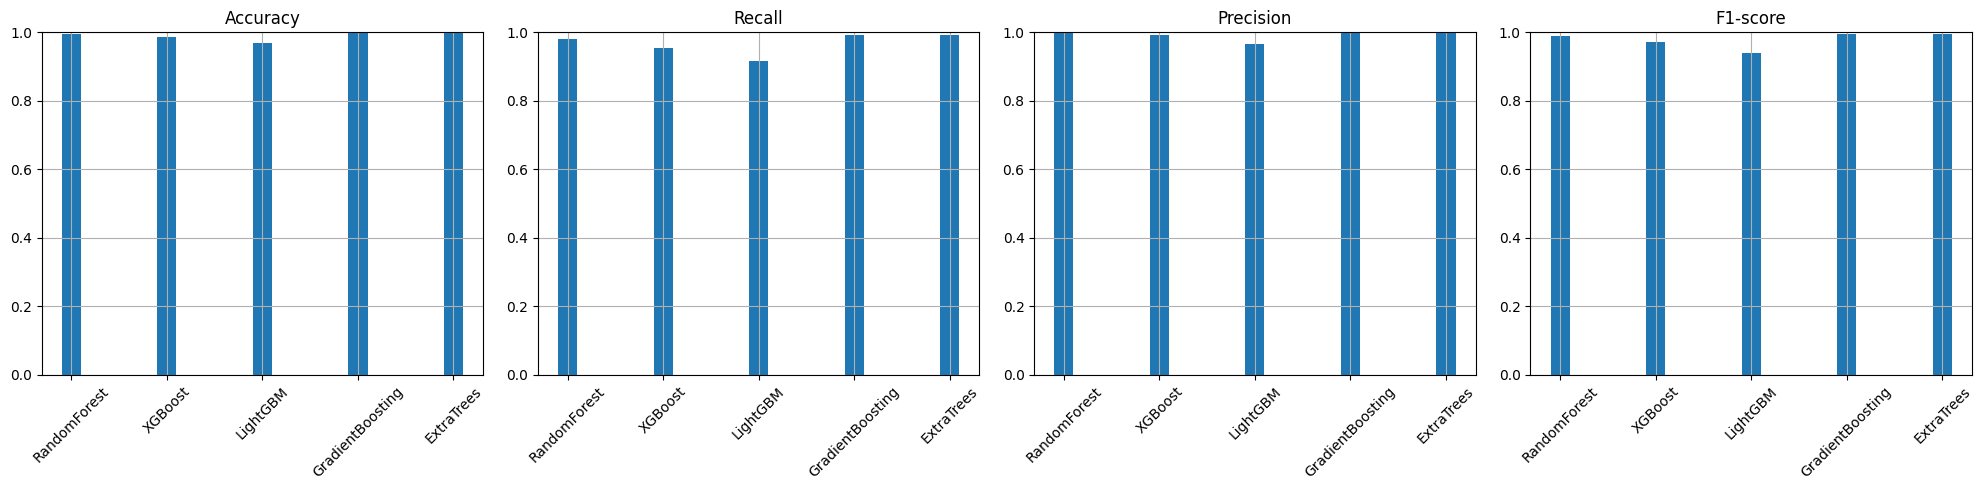

In [ ]:
# Display results from model selection 
alg_labels = list(models.keys())
x = np.arange(len(alg_labels))   
width = 0.2

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, metric in enumerate(["Accuracy", "Recall", "Precision", "F1-score"]):
    axs[i].bar(x, results[metric], width, label=metric)
    axs[i].set_title(metric)
    axs[i].set_ylim(0, 1)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(alg_labels, rotation=45)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

We see that:

* **High Accuracy:** All the models show very high accuracy, close to 1.0. Although accuracy is therefore not a useful metric here.
* **High Precision, Recall, and F1-Score:** All models also show high scores for Precision, Recall, and F1-Score. This is a very strong and positive result. It means the models are not only correctly identifying the majority of non-fraud cases, but they are also doing an excellent job of identifying the minority fraud cases without a high number of false positives.
* **Consistency:** The performance across all the tree-based models is remarkably similar and consistently high across all metrics. This suggests that the features we've selected are highly predictive and that ensemble methods are well-suited for this problem.

While all the models perform exceptionally well, we would select the Gradient Boosting model because Gradient Boosting has built-in mechanisms to handle class imbalance better than the rest, such as the ability to assign different weights to the classes or use specific objective functions. This allows it to focus more on correctly classifying the rare fraud cases, which is critical for this problem.



### **Model Development**

**Cost Sensitivie Learning to Mitigate data imbalance**

In [70]:
# Adjust class weights to deal with imbalance
raw_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
scaling_factor = 0.01
scaled_weights = 1 + scaling_factor * (raw_weights - 1)
weight_dict = {i: w for i, w in enumerate(scaled_weights)}

# Apply sample weights to the training data
sample_weights = np.array([weight_dict[i] for i in y_train])

**Predictive Modelling with Gradient Boosting Machine**

In [71]:
# Train the Gradient Boosting model with instance weights
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train, sample_weight=sample_weights)

GradientBoostingClassifier()

**Disagreement scoring to mitigate noisy data (model vs label)**

In [72]:
# Predicted probabilities on training data
p_train = gb_model.predict_proba(X_train)[:, 1]

disagree = np.abs(p_train - y_train) # High score = likely mislabeled

In [73]:
# Downweight noisy samples
# (strong disagreement gets weight close to 0.5, agreement stays ~1.0)
noise_downweight = 1.0 / (1.0 + 5 * disagree)

In [74]:
# Combine with original class weights
final_weights = sample_weights * noise_downweight

 **Final training with early stopping + conservative regularization**

In [75]:
# Hold out a validation set (time-based split is preferred in fraud settings)
split_idx = int(0.8 * len(X_train))
X_tr, X_val = X_train.iloc[:split_idx], X_train.iloc[split_idx:]
y_tr, y_val = y_train.iloc[:split_idx], y_train.iloc[split_idx:]
w_tr, w_val = final_weights.iloc[:split_idx], final_weights.iloc[split_idx:]

In [76]:
# Final model training with adjusted weights    
gb_model = GradientBoostingClassifier(
    n_estimators=1000,        # allow many trees
    learning_rate=0.05,       # smaller step size
    max_depth=3,              # shallow trees (regularization)
    min_samples_leaf=50,      # prevent overfitting to small noisy subsets
    subsample=0.8,            # stochastic subsampling for robustness
    random_state=42
)

# Fit the model
gb_model.fit(X_tr, y_tr, sample_weight=w_tr)

GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=50,
                           n_estimators=1000, random_state=42, subsample=0.8)

In [77]:
# Early stopping loop
best_iter, best_loss = 0, np.inf
for i, y_pred in enumerate(gb_model.staged_predict_proba(X_val)):
    loss = log_loss(y_val, y_pred[:, 1], sample_weight=w_val)
    if loss < best_loss:
        best_loss, best_iter = loss, i

print(f"Best iteration (early stop) = {best_iter}, best log loss = {best_loss:.4f}")


Best iteration (early stop) = 259, best log loss = 0.1187


**Final fit with best parameters**

In [69]:
# Refit using best number of trees
gb_model.set_params(n_estimators=best_iter + 1)
gb_model.fit(X_tr, y_tr, sample_weight=w_tr)

GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=50,
                           n_estimators=260, random_state=42, subsample=0.8)

### **Model Evaluation**

In [78]:
# Evaluate model on test set
y_predicted = gb_model.predict(X_test) 
accuracy = accuracy_score(y_test, y_predicted)
print("Accuracy:", round(accuracy, 2))

Accuracy: 0.97


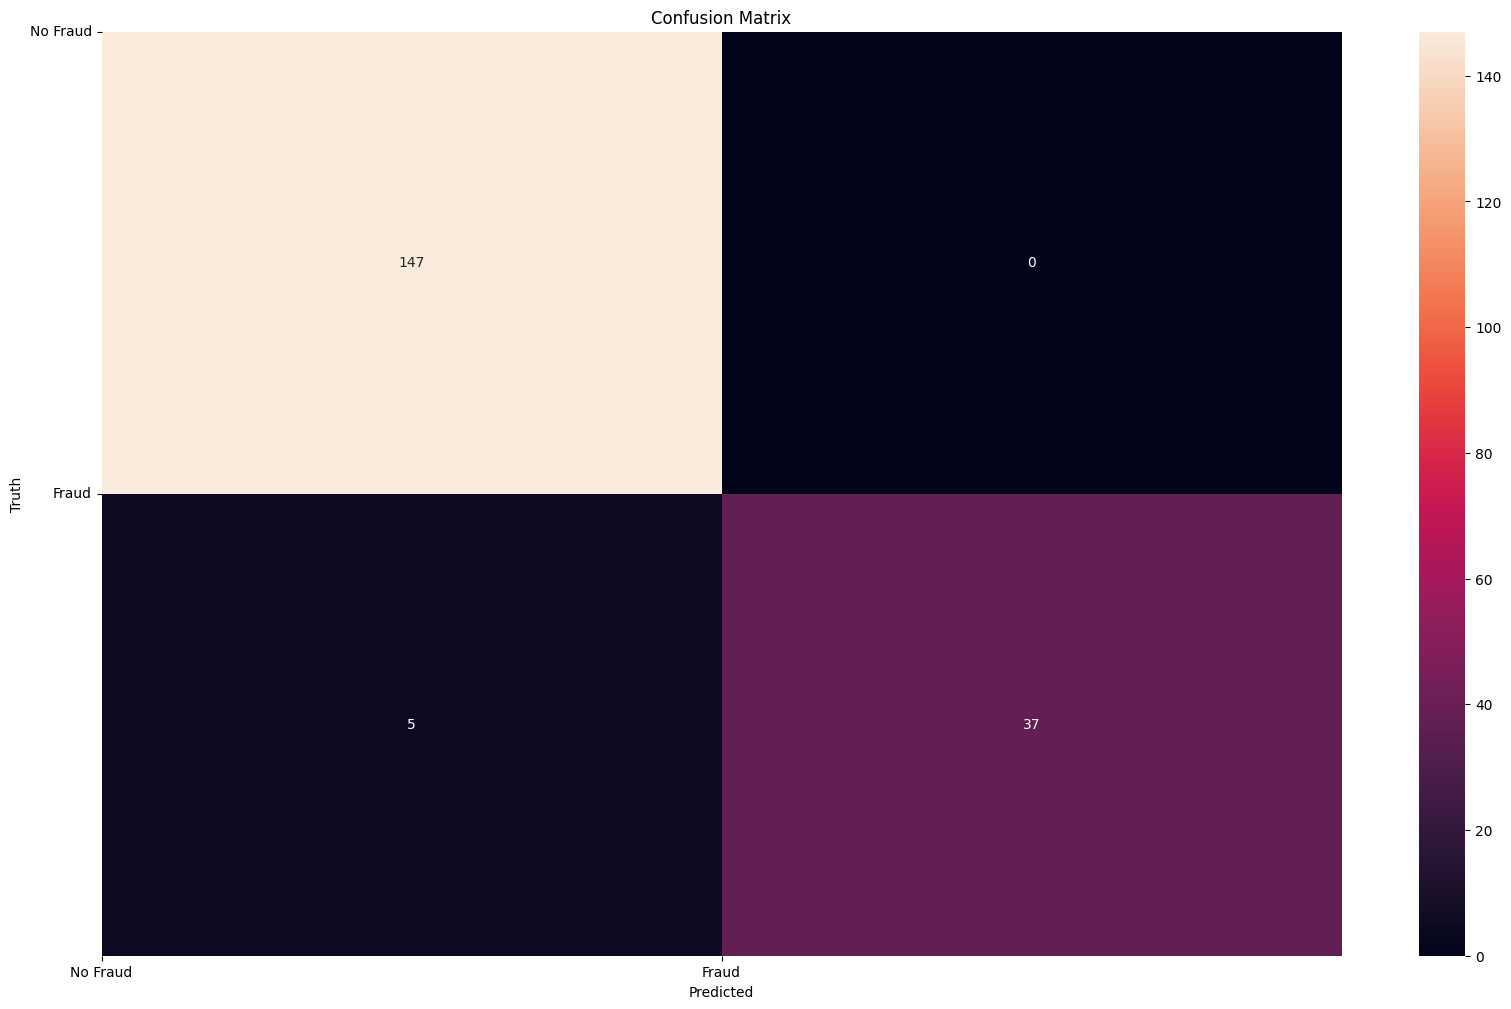

In [79]:
# Display confusion matrix
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_test, y_predicted)
sns.heatmap(cm, annot= True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(label_map))
plt.xticks(tick_marks, label_map.values())
plt.yticks(tick_marks, label_map.values(), rotation='horizontal')
plt.show()

**Classification Report**

In [80]:
# Display classification report
print('Classification Report using Adjusted Class Weights  \n', classification_report(y_test, y_predicted,  target_names=label_map.values()))

Classification Report using Adjusted Class Weights  
               precision    recall  f1-score   support

    No Fraud       0.97      1.00      0.98       147
       Fraud       1.00      0.88      0.94        42

    accuracy                           0.97       189
   macro avg       0.98      0.94      0.96       189
weighted avg       0.97      0.97      0.97       189



**ROC Curve Analysis**

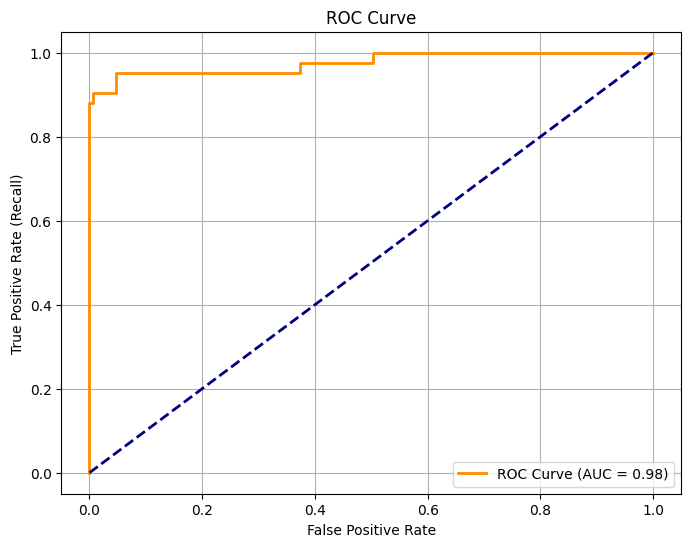

In [81]:
#  Get predicted probabilities for the positive class (fraud = 1)
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Model Performance**

This is a good result for a fraud detection model. Having zero false positives is great, but being able to correctly flag 37 out of the 42 fraudulent transactions in the test set is even a better win. 
* **Classification Report:** 
    * **Precision (Fraud):** **1.00**. This means that of all the transactions the model *predicted* as fraud, **100%** were actually fraudulent. This is truly valuable in this domain.
    * **Recall (Fraud):** **0.88**. This means the model correctly identified **88%** of all the actual fraudulent transactions in the test set. It missed 5 out of 42.
    * **F1-Score (Fraud):** **0.94**. This is reflective of precision and recall. It confirms that the model has good generalization capacity.

Particularly, the model did well in terms of the **The Precision-Recall Trade-off**. This is because, typically, a fraud detection model must choose between these two goals. For example, if you want to catch every single fraudulent transaction (perfect recall), you might have to lower your prediction threshold, which would lead to many legitimate transactions being incorrectly flagged as fraud (low precision). Conversely, if you only want to flag transactions you are 100% certain are fraudulent (perfect precision), you will likely miss some of the more subtle fraud cases (low recall). **The model was abletoperform relatively well on both ends,despite the massive data imbalance challenge**
    

* **ROC Curve:** The **AUC (Area Under the Curve)** is **0.98**, which is a near perfect score. It suggests that there is a threshold that can perfectly separate the fraudulent from the non-fraudulent cases in the data. 

## **Explainability with SHAP**


Understanding *why* a model makes certain predictions is just as important as how well it performs, especially in high-stakes domains like fraud detection. To achieve this, we use **SHAP (SHapley Additive exPlanations)**, a game-theory–based approach that attributes each feature’s contribution to individual predictions.

In this section, we would walk through several levels of explainability:

1. **Global Feature Importance**: Using SHAP summary plots and mean SHAP values, we identify which features most strongly influence the model overall.

2. **Feature Attribution Analysis**: We compute average SHAP contributions across all test transactions to rank features by their global predictive power.

3. **Detailed Feature Contribution (Summary Plots)**: Summary plots show not only the magnitude of feature impact but also the **direction** (whether higher/lower values push towards fraud or non-fraud).This reveals subtle relationships such as “short recency ratios” or “sudden device/location switches” being strong fraud signals.

4. **Local Explanations for Individual Predictions**: We drill down to single transactions using **waterfall plots**. This allows us to see precisely how different features combine to push a prediction towards *fraudulent* or *non-fraudulent*. Alongside, we would inspect the predicted probability of fraud for the same instance, tying the explanation to a concrete decision.

---


**6.1.1 Feature Imporatance**

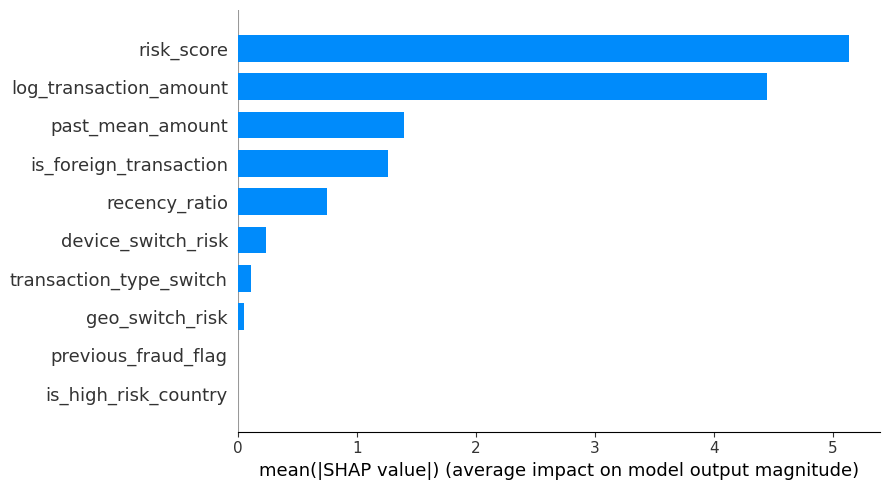

In [82]:
# Feature Importance Plot
explainer = shap.TreeExplainer(gb_model) 
shap_values = explainer.shap_values(X_test)

# Create the plot,
shap.summary_plot(
    shap_values, 
    X_test, 
    plot_type="bar", 
    class_names=list(label_map.values()), 
    show=False   
)

# Display the plot
fig = plt.gcf()
fig.set_size_inches(9, 5)  
plt.tight_layout()
plt.show()

**Key Insights from Feature Importance**

* **`risk_score` is the most important feature.** It means that the `risk_score` variable, likely a pre-calculated measure of a transaction's riskiness, is the single most powerful predictor of fraud in our model.
* **`log_transaction_amount` is also a very strong predictor.** The size of the transaction is the second most important feature. This confirms the earlier scatter plot's insight: higher transaction amounts are a strong indicator of fraud.
* **`is_foreign_transaction` is the third most important feature.** This categorical variable has a significant impact on the model's output. The model learned that foreign transactions are much more likely to be fraudulent.
* **`past_mean_amount` and `recency_ratio` have a moderate impact.** These features, derived from a customer's historical behavior, also play a role in the model's predictions. The model uses a customer's past spending habits to identify deviations that may signal fraud.
* **`previous_fraud_flag`, `is_high_risk_country`, have very little impact.** This is a surprising and important finding. Based on the previous plots, we saw a clear relationship between these features and fraud. The very low SHAP values here could mean a few things:
    1.  **Redundancy:** The information in these features might already be captured by the more important features. For example, `is_high_risk_country` and `is_foreign_transaction` are correlated. The model may have learned to rely on `is_foreign_transaction` and not need the other.
    2.  **Low Variance:** The features might not have enough variation to be useful. For example, the `previous_fraud_flag` is 0 for almost all customers, so the model can't use it to make many predictions.
    3.  **Model Choice:** The specific model might be focusing on the strongest signals and ignoring these less impactful ones.

****Implications for The Model**

* **Feature Importance Validation:** The top features (`risk_score`, `log_transaction_amount`, `is_foreign_transaction`) align with our initial qualitative analysis. These are the most logical and powerful predictors of fraud, and our model has correctly identified them.
* **Multicollinearity Revisited:** The low importance of `is_high_risk_country` is a strong indicator of the multicollinearity we observed earlier. The model has implicitly chosen to rely on `is_foreign_transaction` as the primary indicator, as it likely captures most of the same information.

**Feature Attribution**

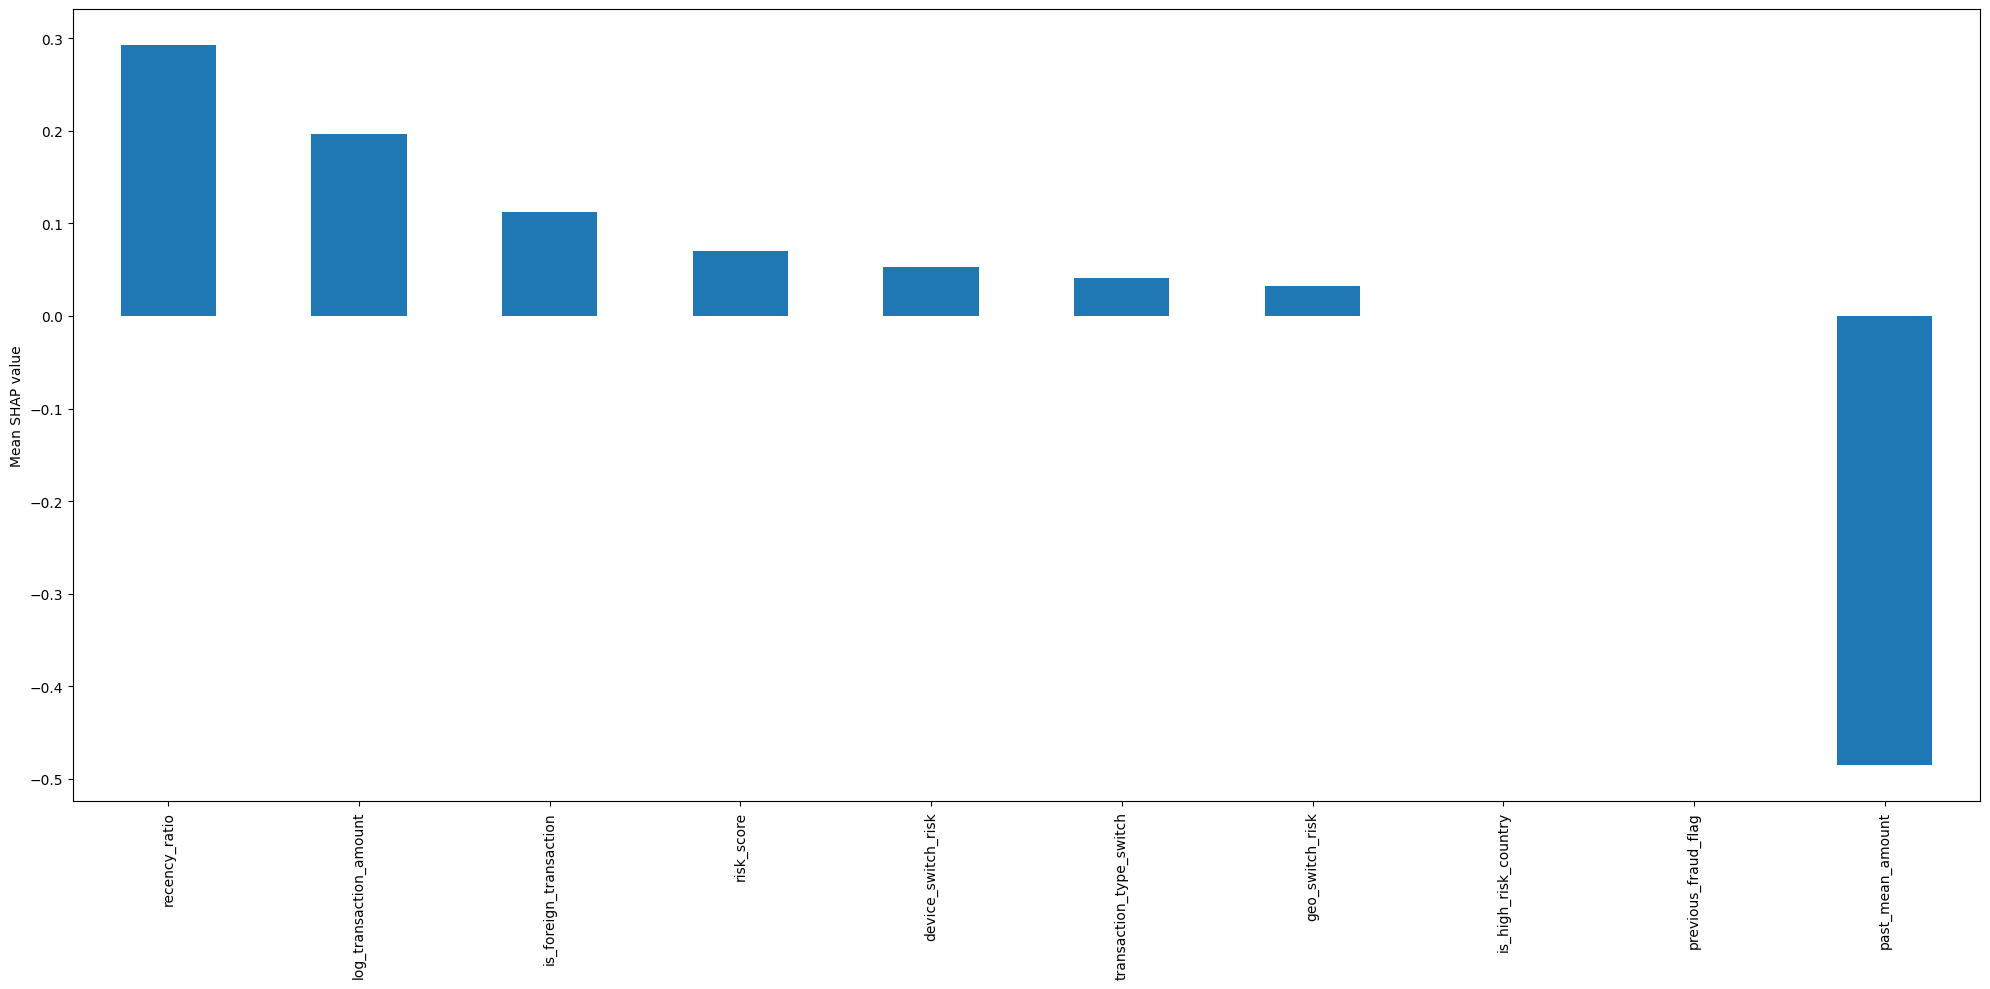

In [83]:
xplainer = explainer(X_test)

# Get mean shap values as a pandas dataframe
# Compute mean shap values per feature
mean_shap = pd.DataFrame(
    np.mean(xplainer.values, axis=0), 
    columns=["mean_shap"],   # <-- only one column
    index=X_train.columns
)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
mean_shap.sort_values("mean_shap", ascending=False).plot.bar(ax=ax, legend=False)
ax.set_ylabel("Mean SHAP value")
plt.tight_layout()
plt.show()


**Insights of Feature Attribution Plot**

The bar chart shows the **mean SHAP value** of each feature, which reflects its average contribution (positive or negative) to the model’s predictions across the test set. The higher the absolute value, the more influential the feature is in driving fraud detection.

Key observations:

1. **Risk Score & Switching Behaviors (device/location/transaction type)**: Risk score and behavioral switches add incremental signals. Device or location changes in short time windows raise suspicion.

2. **Recency Ratio**: Transactions that occur unusually quickly compared to a customer’s historical behavior are strong fraud indicators.

3. **Log Transaction Amount**: Larger transaction sizes contribute meaningfully to fraud risk, which aligns with real-world fraud patterns (suspicious spikes in spending).

4. **Is Foreign Transaction** Transactions marked as foreign strongly increase fraud risk, highlighting geography as a key factor.

5. **Past Mean Amount (negative contribution)** * Past\_mean\_amount has a negative mean SHAP value. This suggests that transactions consistent with a customer’s historical spending reduce the likelihood of being flagged as fraud (a stabilizing feature).

6. **Other Features (is\_high\_risk\_country, previous\_fraud\_flag)** These still play a role but contribute less strongly than the top behavioral and transaction-level features.


**Takeaway**

The model primarily learns fraud patterns from **transaction timing (recency), unusual transaction size, and foreign behavior**, while also penalizing deviations from historical norms. Features like past mean spending appear to act as *protective signals*, reducing false alarms when behavior aligns with a customer’s past.

---


**Local Feature Attribution**

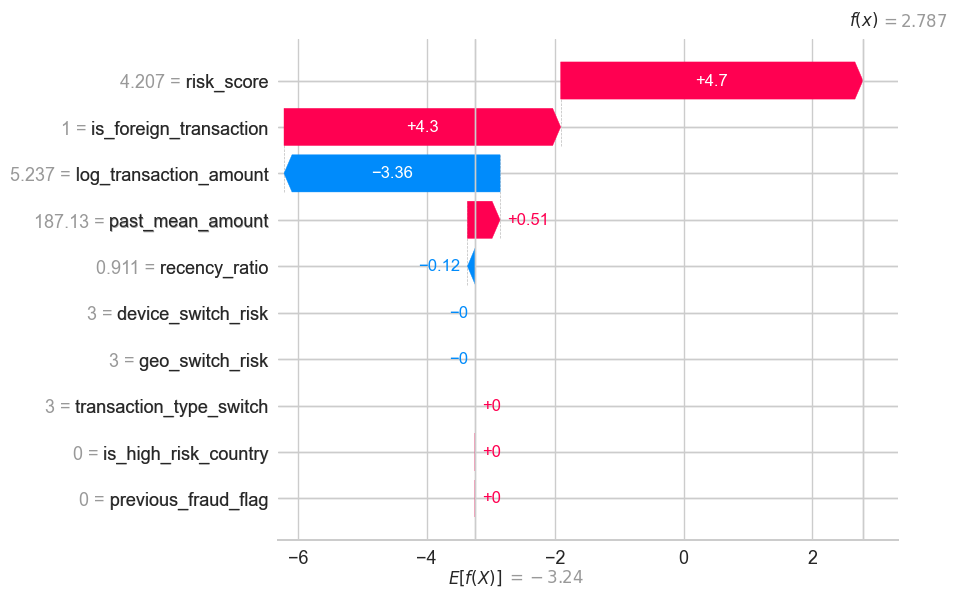

Predicted probability of fraud: 0.94
Predicted class: 1


In [70]:
# Plot SHAP values for a specific instance  
shap.plots.waterfall(xplainer[0])

# Model prediction (probability of fraud)
pred_prob = gb_model.predict_proba(X_test.iloc[[0]])[0, 1]
pred_class = gb_model.predict(X_test.iloc[[0]])[0]

print(f"Predicted probability of fraud: {pred_prob:.2f}")
print(f"Predicted class: {pred_class}")

**Explanation of Local Attribution Plot**

* The **base value** ($E[f(X)]$ = -3.24) is the average model output (the average log-odds of a transaction being fraudulent) across the entire dataset. This is the starting point for the prediction.
* The **final model output** ($f(X)$ = 2.787) is the actual prediction for this specific sample.
* The **red bars** show features that are **pushing the prediction towards a higher fraud risk**. The longer the red bar, the more that feature contributes to the prediction of fraud.
* The **blue bars** show features that are **pushing the prediction towards a lower fraud risk**. The longer the blue bar, the more that feature contributes to the prediction of a non-fraudulent transaction.

**How the Model Arrived at This Prediction**

1.  **Starting Point:** The model began with a baseline prediction of -3.24, which represents the average fraud likelihood.
2.  **Strongest Push Towards Fraud:**
    * **`risk_score`**: The transaction's `risk_score` of 4.207 is a significant driver of fraud, adding a very large positive contribution of +4.7 to the prediction.
    * **`is_foreign_transaction`**: The transaction being a foreign transaction (`1`) adds another large positive contribution of +4.3, strongly pushing the prediction towards fraud.
3.  **Strongest Push Away from Fraud:**
    * **`log_transaction_amount`**: The transaction's `log_transaction_amount` of 5.237 is a strong negative contributor, subtracting -3.36 from the prediction. This means the model views this specific transaction amount as being more typical of a non-fraudulent transaction, despite it being a foreign transaction.
4.  **Minor Contributions:**
    * **`past_mean_amount`**: The customer's `past_mean_amount` adds a small positive contribution of +0.51, suggesting that this transaction amount is slightly higher than the customer's average.
    * **`recency_ratio`**: The `recency_ratio` of 0.911 adds a small negative contribution of -0.12, slightly pushing the prediction away from fraud.
    * **Other features**: All other features (`device_switch_risk`, `geo_switch_risk`, `transaction_type_switch`, `is_high_risk_country`, `previous_fraud_flag`) had a negligible impact (around 0). This confirms that they did not play a significant role in this specific prediction.

**Interpreting the Plot's Values**

When a SHAP force plot shows a single prediction, you can think of it as a tug-of-war. The **base value ($E[f(x)]$**) is the average prediction across the entire dataset. The red and blue bars show which features are pulling the prediction up or down from that average for a specific instance. The final predicted value ($f(x)$) is the result of this tug-of-war.

If the final prediction score is **positive**, it means the sum of the positive (red) SHAP values was greater than the sum of the negative (blue) SHAP values. The model's final decision is a prediction of fraud. If the final score is **negative**, the opposite is true, and the model predicts non-fraud.

**Final Conclusion**

The model started with a negative log-odds baseline and was then heavily influenced by two powerful fraud indicators: a high `risk_score` and the fact that it was a foreign transaction. While a relatively high `log_transaction_amount` pushed the prediction back towards "non-fraud," the combined positive contributions from `risk_score` and `is_foreign_transaction` were so strong that the model's final prediction became positive (2.787), indicating that this transaction is highly likely to be fraudulent,as confirmedby the models prediction (1=Fraud) and probability(0.94)





In [71]:
# Save trained model to a path
joblib.dump(gb_model, "./src/models/fraud_model.pkl")

['./src/models/fraud_model.pkl']

## **6. Unsupervised Transaction Clustering**

In [72]:
# Preview current state of dataframe
df.head()

,transaction_id,customer_id,transaction_amount,transaction_type,device_type,location,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,risk_score,_hour,_day,_month,_is_weekend,_month_name,_weekend_name,Label,log_transaction_amount,past_mean_amount,recency_ratio,geo_switch_risk,device_switch_risk,transaction_type_switch
0,TX100292,CUST1063,122.10,Online,POS Terminal,Abuja,Evening,Fri,1,0,0,1,2024-01-01 00:00:00,2.52,0,1,1,0,January,Weekday,Fraud,4.81,122.10,1.00,2,2,2
1,TX100955,CUST1007,25.64,Transfer,ATM Machine,Ibadan,Afternoon,Sat,0,0,0,0,2024-01-01 01:00:00,0.20,1,1,1,0,January,Weekday,No Fraud,3.28,25.64,1.00,2,2,2
2,TX100338,CUST1072,45.06,POS,Web,Abuja,Afternoon,Thu,0,0,0,0,2024-01-01 02:00:00,0.42,2,1,1,0,January,Weekday,No Fraud,3.83,45.06,1.00,2,2,2
3,TX100668,CUST1052,18.40,POS,Web,Kano,Morning,Mon,0,0,0,0,2024-01-01 03:00:00,0.17,3,1,1,0,January,Weekday,No Fraud,2.97,18.40,1.00,2,2,2
4,TX100487,CUST1092,20.38,Online,Web,Ibadan,Afternoon,Thu,0,0,0,0,2024-01-01 04:00:00,0.21,4,1,1,0,January,Weekday,No Fraud,3.06,20.38,1.00,2,2,2


In [73]:
# Remove Fradulent transaction
legit_df = df[df['label_code'] == 0]

#### **Prepare Data For Clustering**

In [74]:
def aggregate_to_customers(
    tx_df,
    customer_id_col="customer_id",
    transaction_time_col="transaction_time",
    categorical_cols=None,
    fillna_value=0.0
):
    """
    transaction-level -> customer-level.

    Returns a DataFrame with one row per customer and columns including:
      - txn_count, total_amount, mean_amount, std_amount, median_amount, avg_ticket
      - foreign_txn_share, weekend_share (if present)
      - recency_ratio_{mean,std,median} (if present)
      - hour/day/month mean/std (if present)
      - intertxn_* statistics
      - <cat>_unique_count, <cat>_mode (optional), <cat>_mode_frac, <cat>_entropy for each cat in categorical_cols
      - <col>_switches and <col>_switch_rate for device_type/location/transaction_type/time_of_day/day_of_week
    """

    tx = tx_df.copy()

    # helper entropy
    def _entropy_from_counts(counts):
        total = float(np.sum(counts))
        if total <= 0:
            return 0.0
        ps = [c/total for c in counts if c > 0]
        return float(-sum(p * np.log2(p) for p in ps))

    # groupby
    g = tx.groupby(customer_id_col)

    # -----------------------
    # Basic numeric aggregates
    # -----------------------
    txn_count = g.size().rename("txn_count")

    amt = g["transaction_amount"].agg(["sum","mean","std","median"]).rename(columns={
            "sum":"total_amount","mean":"mean_amount","std":"std_amount","median":"median_amount"
        })

    # foreign/weekend
    foreign_share = g["is_foreign_transaction"].mean().rename("foreign_txn_share") 
    weekend_share = g["_is_weekend"].mean().rename("weekend_share")

    # recency_ratio block
    recency_block = pd.DataFrame(index=txn_count.index)
    recency_block = g["recency_ratio"].agg(["mean","std","median"]).rename(columns={
            "mean":"recency_ratio_mean","std":"recency_ratio_std","median":"recency_ratio_median"
        })

    # time-of-day numeric aggregates (hour/day/month) - use underscore-prefixed names when present
    time_cols = {}
    time_cols["hour_mean"] = g["_hour" ].mean()
    time_cols["hour_std"]  = g["_hour" ].std()

    time_cols["day_mean"] = g["_day"].mean()
    time_cols["day_std"]  = g["_day"].std()

    time_cols["month_mean"] = g["_month"].mean()
    time_cols["month_std"]  = g["_month"].std()

    time_agg_df = pd.concat([s.rename(k) for k,s in time_cols.items()], axis=1)

    # -----------------------
    # Session & switch stats
    # -----------------------
    def _session_and_switch_stats(subdf):
        out = {}
        # inter-transaction times (seconds)
        if transaction_time_col in subdf.columns:
            sub = subdf.sort_values(by=transaction_time_col)
            times = sub[transaction_time_col].dropna()
            deltas = times.diff().dt.total_seconds().dropna()
            if len(deltas) > 0:
                out["intertxn_mean_s"] = float(deltas.mean())
                out["intertxn_std_s"] = float(deltas.std()) if deltas.std()==deltas.std() else 0.0
                out["intertxn_median_s"] = float(deltas.median())
                out["intertxn_min_s"] = float(deltas.min())
                out["intertxn_max_s"] = float(deltas.max())
            else:
                out.update({"intertxn_mean_s":np.nan,"intertxn_std_s":np.nan,"intertxn_median_s":np.nan,"intertxn_min_s":np.nan,"intertxn_max_s":np.nan})
        else:
            out.update({"intertxn_mean_s":np.nan,"intertxn_std_s":np.nan,"intertxn_median_s":np.nan,"intertxn_min_s":np.nan,"intertxn_max_s":np.nan})

        # switches for a fixed set of important cols (safe even if absent)
        for col in categorical_cols:
            if col in subdf.columns:
                s = subdf[col].astype(str)
                neq = (s != s.shift()).sum()
                switches = max(0, int(neq - 1))
                denom = max(1, len(s)-1)
                out[f"{col}_switches"] = switches
                out[f"{col}_switch_rate"] = (switches / denom) if denom>0 else 0.0
            else:
                out[f"{col}_switches"] = 0
                out[f"{col}_switch_rate"] = 0.0

        return pd.Series(out)

    session_switch_df = g.apply(_session_and_switch_stats)

    # -----------------------
    # Categorical summaries (computed per category but built as uniform DataFrames)
    # -----------------------
    cat_summary_frames = []
    for cat in categorical_cols:
        if cat not in tx.columns:
            # skip missing categories but keep consistent numeric placeholders if you want
            continue

        # unique_count
        unique_count = g[cat].nunique().rename(f"{cat}_unique_count")

        # mode (string)
        def _mode_func(x):
            x = x.dropna().astype(str)
            if x.empty:
                return np.nan
            m = x.mode()
            return m.iloc[0] if len(m)>0 else np.nan
        mode_series = g[cat].apply(_mode_func).rename(f"{cat}_mode")

        # mode_frac (proportion of top category)
        def _mode_frac_func(x):
            x = x.dropna().astype(str)
            if x.empty:
                return 0.0
            vc = x.value_counts(normalize=True)
            return float(vc.iloc[0])
        mode_frac = g[cat].apply(_mode_frac_func).rename(f"{cat}_mode_frac")

        # entropy
        def _entropy_func(x):
            x = x.dropna().astype(str)
            if x.empty:
                return 0.0
            vc = x.value_counts().values
            return _entropy_from_counts(vc)
        entropy = g[cat].apply(_entropy_func).rename(f"{cat}_entropy")

        s = pd.concat([unique_count, mode_series, mode_frac, entropy], axis=1)
        cat_summary_frames.append(s)

    cat_summary_df = pd.concat(cat_summary_frames, axis=1) if cat_summary_frames else pd.DataFrame(index=txn_count.index)

    # -----------------------
    # Final merge
    # -----------------------
    pieces = [txn_count, amt, foreign_share, weekend_share]
    if not recency_block.empty:
        pieces.append(recency_block)
    if not time_agg_df.empty:
        pieces.append(time_agg_df)

    core_df = pd.concat(pieces, axis=1)
    cust = pd.concat([core_df, session_switch_df, cat_summary_df], axis=1)

    # clean and fill
    cust = cust.fillna(fillna_value)
    cust = cust.reset_index().rename(columns={customer_id_col: "customer_id"})


    return cust

In [76]:
# Define categorical features for clustering
clust_categorical_features = ["device_type","location","transaction_type", "time_of_day", "day_of_week"]

# Apply the aggregation function    
customer_features = aggregate_to_customers(legit_df, categorical_cols=clust_categorical_features)

# Inspect the result
customer_features.head()

/var/folders/rh/bvr0p9hd7sg3x6qmjpjfst0c0000gn/T/ipykernel_39126/1290637245.py:102: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,customer_id,txn_count,total_amount,mean_amount,std_amount,median_amount,foreign_txn_share,weekend_share,recency_ratio_mean,recency_ratio_std,recency_ratio_median,hour_mean,hour_std,day_mean,day_std,month_mean,month_std,intertxn_mean_s,intertxn_std_s,intertxn_median_s,intertxn_min_s,intertxn_max_s,device_type_switches,device_type_switch_rate,location_switches,location_switch_rate,transaction_type_switches,transaction_type_switch_rate,time_of_day_switches,time_of_day_switch_rate,day_of_week_switches,day_of_week_switch_rate,device_type_unique_count,device_type_mode,device_type_mode_frac,device_type_entropy,location_unique_count,location_mode,location_mode_frac,location_entropy,transaction_type_unique_count,transaction_type_mode,transaction_type_mode_frac,transaction_type_entropy,time_of_day_unique_count,time_of_day_mode,time_of_day_mode_frac,time_of_day_entropy,day_of_week_unique_count,day_of_week_mode,day_of_week_mode_frac,day_of_week_entropy
0,CUST1000,5,749.53,149.91,41.78,166.05,0.00,0.20,0.91,0.08,0.90,15.00,5.83,15.60,10.99,1.20,0.45,678600.00,414500.57,698400.00,223200.00,1094400.00,4.00,1.00,2.00,0.50,1.00,0.25,1.00,0.25,2.00,0.50,4,POS Terminal,0.40,1.92,2,Kano,0.60,0.97,2,POS,0.80,0.72,2,Night,0.60,0.97,3,Mon,0.40,1.52
1,CUST1001,5,597.68,119.54,55.87,115.28,0.00,0.20,1.54,0.91,1.13,10.60,7.54,22.80,8.23,1.00,0.00,448200.00,473784.25,329400.00,14400.00,1119600.00,4.00,1.00,3.00,0.75,1.00,0.25,1.00,0.25,4.00,1.00,3,Mobile,0.40,1.52,4,Port Harcourt,0.40,1.92,2,Online,0.80,0.72,2,Night,0.60,0.97,3,Fri,0.40,1.52
2,CUST1002,4,319.50,79.88,111.23,31.27,0.00,0.00,0.97,0.06,1.00,14.75,6.99,14.25,11.24,1.25,0.50,643200.00,443784.27,392400.00,381600.00,1155600.00,1.00,0.33,3.00,1.00,2.00,0.67,1.00,0.33,3.00,1.00,2,ATM Machine,0.50,1.00,4,Abuja,0.25,2.00,3,POS,0.50,1.50,2,Night,0.75,0.81,4,Fri,0.25,2.00
3,CUST1003,8,649.32,81.17,52.70,86.09,0.00,0.12,0.98,0.11,1.00,11.50,7.41,16.50,7.82,1.25,0.46,409885.71,258134.72,439200.00,93600.00,885600.00,4.00,0.57,4.00,0.57,7.00,1.00,5.00,0.71,6.00,0.86,3,ATM Machine,0.50,1.41,5,Ibadan,0.38,2.16,4,Online,0.38,1.91,3,Morning,0.50,1.50,5,Sat,0.50,2.00
4,CUST1004,6,550.52,91.75,113.99,56.62,0.00,0.50,1.07,0.12,1.00,9.67,3.88,10.00,11.05,1.33,0.52,694800.00,524322.42,608400.00,115200.00,1414800.00,4.00,0.80,4.00,0.80,4.00,0.80,3.00,0.60,5.00,1.00,4,Mobile,0.33,1.92,5,Abuja,0.33,2.25,3,ATM,0.50,1.46,3,Morning,0.50,1.46,6,Mon,0.17,2.58


In [77]:
# Check shape
print("Encoded shape:", customer_features.shape)

Encoded shape: (101, 52)


**Feature Selection**

In [ ]:
# def drop_low_variance_features(df, num_var_threshold=0.01, cat_dominance_threshold=0.95):
#     """
#     Drops low variance features for both numeric and categorical columns.

#     Parameters
#     ----------
#     df : pd.DataFrame
#         Customer-level feature dataset.
#     num_var_threshold : float
#         Minimum variance required for numeric features to be kept.
#     cat_dominance_threshold : float
#         If the most frequent category proportion > threshold, drop the categorical feature.

#     Returns
#     -------
#     filtered_df : pd.DataFrame
#         Dataset with low-variance features removed.
#     dropped_features : dict
#         Dictionary with keys 'numeric' and 'categorical' listing dropped features.
#     """
    
#     dropped_features = {"numeric": [], "categorical": []}

#     # --- Numeric features ---
#     num_df = df.select_dtypes(include=[np.number])
#     num_var = num_df.var()
#     low_var_num = num_var[num_var < num_var_threshold].index.tolist()
#     dropped_features["numeric"].extend(low_var_num)

#     # --- Categorical features ---
#     cat_df = df.select_dtypes(exclude=[np.number])
#     low_var_cat = []
#     for col in cat_df.columns:
#         top_frac = cat_df[col].value_counts(normalize=True, dropna=False).iloc[0]
#         if top_frac > cat_dominance_threshold:
#             low_var_cat.append(col)
#     dropped_features["categorical"].extend(low_var_cat)

#     # --- Drop low variance features ---
#     to_drop = low_var_num + low_var_cat
#     filtered_df = df.drop(columns=to_drop)

#     return filtered_df, dropped_features

# filtered_features, dropped = drop_low_variance_features(customer_features)
# print("Dropped numeric features:", dropped["numeric"])
# print("Dropped categorical features:", dropped["categorical"])

Dropped numeric features: ['foreign_txn_share']
Dropped categorical features: []


In [78]:
# Make a copy
customer_features_encoded = customer_features.copy()

# Select categorical (object/string) columns
cat_cols = customer_features_encoded.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns found:", cat_cols)

# One-hot encode them
customer_features_encoded = pd.get_dummies(
    customer_features_encoded,
    columns=cat_cols,
    prefix=cat_cols,
    drop_first=False,
    dtype=int
)

# Check shape
print("Encoded shape:", customer_features_encoded.shape)

# Preview
customer_features_encoded.head()

Categorical columns found: ['device_type_mode', 'location_mode', 'transaction_type_mode', 'time_of_day_mode', 'day_of_week_mode']
Encoded shape: (101, 71)


,customer_id,txn_count,total_amount,mean_amount,std_amount,median_amount,foreign_txn_share,weekend_share,recency_ratio_mean,recency_ratio_std,recency_ratio_median,hour_mean,hour_std,day_mean,day_std,month_mean,month_std,intertxn_mean_s,intertxn_std_s,intertxn_median_s,intertxn_min_s,intertxn_max_s,device_type_switches,device_type_switch_rate,location_switches,location_switch_rate,transaction_type_switches,transaction_type_switch_rate,time_of_day_switches,time_of_day_switch_rate,day_of_week_switches,day_of_week_switch_rate,device_type_unique_count,device_type_mode_frac,device_type_entropy,location_unique_count,location_mode_frac,location_entropy,transaction_type_unique_count,transaction_type_mode_frac,transaction_type_entropy,time_of_day_unique_count,time_of_day_mode_frac,time_of_day_entropy,day_of_week_unique_count,day_of_week_mode_frac,day_of_week_entropy,device_type_mode_ATM Machine,device_type_mode_Mobile,device_type_mode_POS Terminal,device_type_mode_Web,location_mode_Abuja,location_mode_Ibadan,location_mode_Kano,location_mode_Lagos,location_mode_Port Harcourt,transaction_type_mode_ATM,transaction_type_mode_Online,transaction_type_mode_POS,transaction_type_mode_Transfer,time_of_day_mode_Afternoon,time_of_day_mode_Evening,time_of_day_mode_Morning,time_of_day_mode_Night,day_of_week_mode_Fri,day_of_week_mode_Mon,day_of_week_mode_Sat,day_of_week_mode_Sun,day_of_week_mode_Thu,day_of_week_mode_Tue,day_of_week_mode_Wed
0,CUST1000,5,749.53,149.91,41.78,166.05,0.00,0.20,0.91,0.08,0.90,15.00,5.83,15.60,10.99,1.20,0.45,678600.00,414500.57,698400.00,223200.00,1094400.00,4.00,1.00,2.00,0.50,1.00,0.25,1.00,0.25,2.00,0.50,4,0.40,1.92,2,0.60,0.97,2,0.80,0.72,2,0.60,0.97,3,0.40,1.52,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
1,CUST1001,5,597.68,119.54,55.87,115.28,0.00,0.20,1.54,0.91,1.13,10.60,7.54,22.80,8.23,1.00,0.00,448200.00,473784.25,329400.00,14400.00,1119600.00,4.00,1.00,3.00,0.75,1.00,0.25,1.00,0.25,4.00,1.00,3,0.40,1.52,4,0.40,1.92,2,0.80,0.72,2,0.60,0.97,3,0.40,1.52,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
2,CUST1002,4,319.50,79.88,111.23,31.27,0.00,0.00,0.97,0.06,1.00,14.75,6.99,14.25,11.24,1.25,0.50,643200.00,443784.27,392400.00,381600.00,1155600.00,1.00,0.33,3.00,1.00,2.00,0.67,1.00,0.33,3.00,1.00,2,0.50,1.00,4,0.25,2.00,3,0.50,1.50,2,0.75,0.81,4,0.25,2.00,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
3,CUST1003,8,649.32,81.17,52.70,86.09,0.00,0.12,0.98,0.11,1.00,11.50,7.41,16.50,7.82,1.25,0.46,409885.71,258134.72,439200.00,93600.00,885600.00,4.00,0.57,4.00,0.57,7.00,1.00,5.00,0.71,6.00,0.86,3,0.50,1.41,5,0.38,2.16,4,0.38,1.91,3,0.50,1.50,5,0.50,2.00,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
4,CUST1004,6,550.52,91.75,113.99,56.62,0.00,0.50,1.07,0.12,1.00,9.67,3.88,10.00,11.05,1.33,0.52,694800.00,524322.42,608400.00,115200.00,1414800.00,4.00,0.80,4.00,0.80,4.00,0.80,3.00,0.60,5.00,1.00,4,0.33,1.92,5,0.33,2.25,3,0.50,1.46,3,0.50,1.46,6,0.17,2.58,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0


**Standardize the data**

In [79]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_features_encoded.iloc[:, 1:])

**Choose K using Elbow and  Silhouette methods**

In [81]:
K_RANGE = list(range(2, 11))  # K values to check
RANDOM_STATE = 42
OUT_DIR = "./src/explain"

In [82]:
def find_best_k(X, k_range=K_RANGE):
    inertias = []
    silhouettes = []
    tried_k = []
    for k in k_range:
        if k < 2 or k >= X.shape[0]:
            continue
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20, max_iter=300)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        try:
            sil = silhouette_score(X, labels)
        except Exception:
            sil = np.nan
        silhouettes.append(sil)
        tried_k.append(k)
        print(f"k={k} inertia={km.inertia_:.2f} silhouette={sil:.4f}")
    return tried_k, inertias, silhouettes

In [83]:
# Find the best K using the scaled features
k_vals, inertias, silhouettes = find_best_k(X_scaled, k_range=K_RANGE)

k=2 inertia=6092.74 silhouette=0.1260
k=3 inertia=5711.79 silhouette=0.1209
k=4 inertia=5479.38 silhouette=0.0535
k=5 inertia=5214.48 silhouette=0.0475
k=6 inertia=5052.52 silhouette=0.0351
k=7 inertia=4900.66 silhouette=0.0336
k=8 inertia=4788.55 silhouette=0.0395
k=9 inertia=4657.78 silhouette=0.0382
k=10 inertia=4510.13 silhouette=0.0335


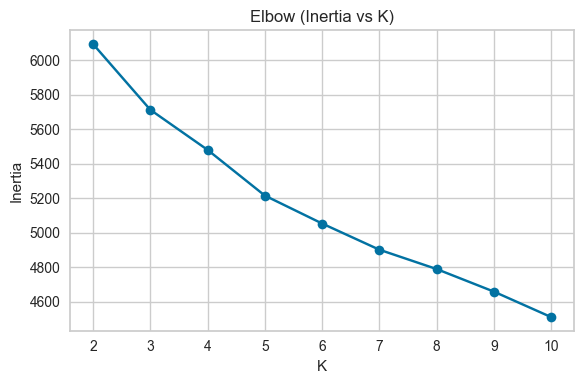

In [84]:
# Plotting the Elbow curve
plt.figure(figsize=(6,4))
plt.plot(k_vals, inertias, marker="o")
plt.title("Elbow (Inertia vs K)")
plt.xlabel("K"); plt.ylabel("Inertia"); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"elbow.png")); plt.show()

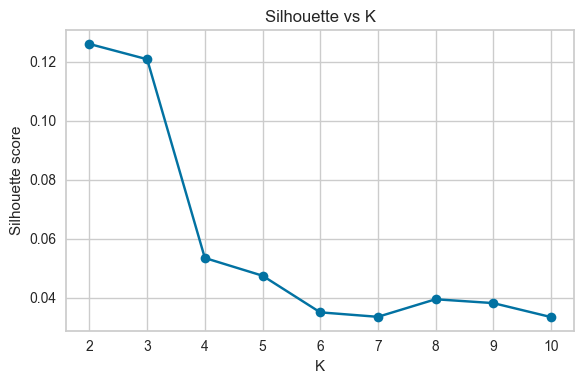

In [85]:
# Plotting the Silhouette curve
plt.figure(figsize=(6,4))
plt.plot(k_vals, silhouettes, marker="o")
plt.title("Silhouette vs K")
plt.xlabel("K"); plt.ylabel("Silhouette score"); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,"silhouette.png")); plt.show()

In [86]:
best_idx = int(np.nanargmax(silhouettes))
best_k = k_vals[best_idx]
print(f"Selected K (silhouette peak): {best_k} (silhouette={silhouettes[best_idx]:.4f})")

Selected K (silhouette peak): 2 (silhouette=0.1260)


**Fit final KMeans and assign clusters**

In [87]:
# Final KMeans clustering
final_km = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=50, max_iter=500)
customer_features["cluster"] = final_km.fit_predict(X_scaled)
cust_out = customer_features.reset_index().rename(columns={"index":"customer_id"})
cust_out.to_csv(os.path.join(OUT_DIR,"customer_clusters.csv"), index=False)
print(f"Saved customer clusters to {OUT_DIR}/customer_clusters.csv")

Saved customer clusters to ./src/explain/customer_clusters.csv


**Cluster profiling & top drivers (z-scores)**

In [88]:
# select only numeric features for profiling
feature_cols = customer_features.select_dtypes(include=[np.number]).columns.drop(["cluster"])
cluster_profiles = customer_features.groupby("cluster")[feature_cols].mean().round(4)
cluster_profiles.to_csv(os.path.join(OUT_DIR,"cluster_profiles.csv"))
print(f"Saved cluster profiles to {OUT_DIR}/cluster_profiles.csv")


Saved cluster profiles to ./src/explain/cluster_profiles.csv


In [89]:
# compute z-scores of cluster means vs global mean
global_mean = customer_features[feature_cols].mean()
global_std = customer_features[feature_cols].std().replace(0, np.nan)
z_profiles = (cluster_profiles - global_mean) / global_std

In [90]:
# Identify top drivers per cluster
def top_drivers_per_cluster(z_profiles, top_n=5):
    drivers = {}
    for c in z_profiles.index:
        row = z_profiles.loc[c].dropna()
        top_pos = row.sort_values(ascending=False).head(top_n)
        top_neg = row.sort_values(ascending=True).head(top_n)
        drivers[c] = {"positive": top_pos.to_dict(), "negative": top_neg.to_dict()}
    return drivers

In [91]:
drivers = top_drivers_per_cluster(z_profiles, top_n=5)
print("\nTop drivers per cluster (z-scores):")
for cid, drv in drivers.items():
    print(f"\nCluster {cid} TOP +")
    for f,z in drv["positive"].items():
        print(f"  {f}: z={z:.2f}")
    print(f"Cluster {cid} TOP -")
    for f,z in drv["negative"].items():
        print(f"  {f}: z={z:.2f}")


Top drivers per cluster (z-scores):

Cluster 0 TOP +
  txn_count: z=0.62
  day_of_week_switches: z=0.61
  location_switches: z=0.61
  day_of_week_unique_count: z=0.59
  day_of_week_entropy: z=0.57
Cluster 0 TOP -
  day_of_week_mode_frac: z=-0.42
  intertxn_mean_s: z=-0.37
  intertxn_max_s: z=-0.35
  intertxn_median_s: z=-0.34
  intertxn_std_s: z=-0.34

Cluster 1 TOP +
  day_of_week_mode_frac: z=0.61
  intertxn_mean_s: z=0.54
  intertxn_max_s: z=0.51
  intertxn_median_s: z=0.50
  intertxn_std_s: z=0.50
Cluster 1 TOP -
  txn_count: z=-0.90
  day_of_week_switches: z=-0.89
  location_switches: z=-0.89
  day_of_week_unique_count: z=-0.86
  day_of_week_entropy: z=-0.84


**Cluster 0** – High Activity, Diverse Transaction Patterns

**Top Positive Drivers**

* High transaction count (`txn_count`)
* Frequent day-of-week switches & location switches
* High diversity in transaction days (`unique_count`, entropy)

**Top Negative Drivers**

* Low concentration on a single day (`day_of_week_mode_frac`)
* Shorter inter-transaction times (lower mean, max, median, std)

**Business Interpretation**
This cluster likely represents **highly active, dynamic customers**:

* They transact frequently, across multiple days and locations.
* Their behavior is diverse and fast-paced, with relatively short gaps between transactions.

**Potential Business Use Cases**

* **Fraud Monitoring:** Frequent switching in time, location, and day-of-week makes them harder to distinguish from fraudsters.
* **Engagement Opportunities:** These customers are highly engaged; they could be targeted with loyalty programs, premium services, or cross-selling opportunities.
* **Risk Flagging:** Unusual bursts in activity could be flagged more strictly here, since baseline activity is already high.

---

**Cluster 1** – Low Activity, Consistent Transaction Behavior

**Top Positive Drivers**

* Higher concentration on a single day (`day_of_week_mode_frac`)
* Longer inter-transaction times (higher mean, max, median, std)

**Top Negative Drivers**

* Lower transaction count (`txn_count`)
* Fewer switches across days, locations, and transaction diversity

**Business Interpretation**
This cluster represents **low-frequency, routine customers**:

* They transact less often and mostly on predictable days.
* They have long gaps between transactions, with stable, repetitive patterns.

**Potential Business Use Cases**

* **Fraud Detection:** Easier to spot anomalies — e.g., a sudden location switch or burst in transaction count would strongly deviate from the baseline.
* **Customer Retention:** These customers may be less engaged; marketing could design nudges (e.g., promotions or reminders) to encourage more consistent activity.
* **Risk Assessment:** Their stable behavior may be used as a benchmark for “normal” patterns against which other customers are evaluated.

---


In [92]:
# Save drivers
with open(os.path.join(OUT_DIR,"cluster_top_drivers.txt"), "w") as fh:
    for cid, drv in drivers.items():
        fh.write(f"Cluster {cid} TOP +\n")
        for f,z in drv["positive"].items():
            fh.write(f"  {f}: z={z:.2f}\n")
        fh.write(f"Cluster {cid} TOP -\n")
        for f,z in drv["negative"].items():
            fh.write(f"  {f}: z={z:.2f}\n")
        fh.write("\n")
print(f"Saved cluster top drivers to {OUT_DIR}/cluster_top_drivers.txt")

Saved cluster top drivers to ./src/explain/cluster_top_drivers.txt


**Cluster visualization (using dimensionality reduction(PCA)**

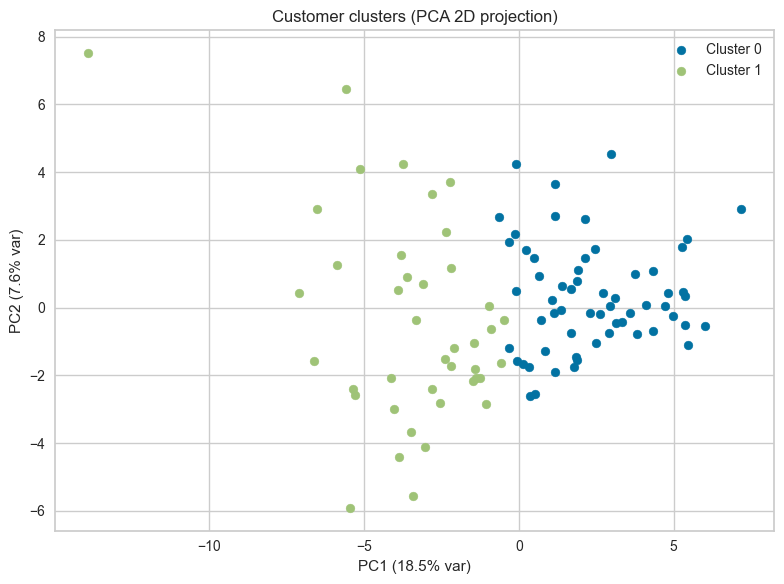

Saved PCA plot to ./src/explain/pca_2d.png


In [93]:
# Fit PCA with 2 components
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_

# 2D scatter plot
plt.figure(figsize=(8,6))

for c in sorted(customer_features["cluster"].unique()):
    mask = customer_features["cluster"] == c
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=f"Cluster {c}",
        s=40
    )

plt.xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
plt.title("Customer clusters (PCA 2D projection)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pca_2d.png"))
plt.show()

print(f"Saved PCA plot to {OUT_DIR}/pca_2d.png")


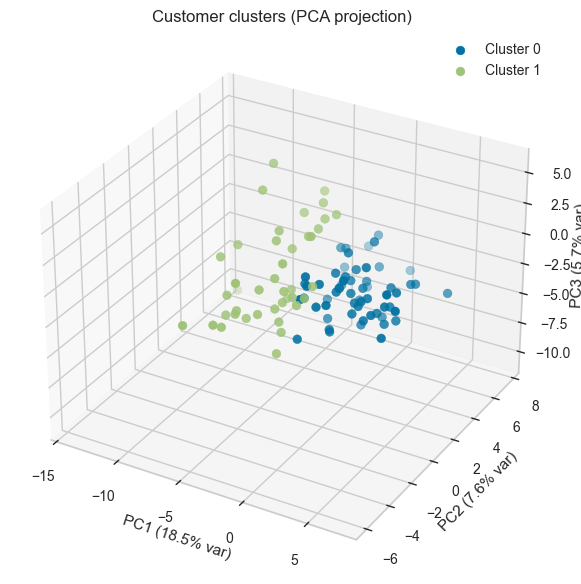

Saved PCA plot to ./src/explain/pca_3d.png


In [94]:
# Fit PCA with 3 components
pca = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_

# 3D scatter plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for c in sorted(customer_features["cluster"].unique()):
    mask = customer_features["cluster"] == c
    ax.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        X_pca[mask, 2],
        label=f"Cluster {c}",
        s=40
    )

ax.set_xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
ax.set_zlabel(f"PC3 ({explained[2]*100:.1f}% var)")
ax.legend()

plt.title("Customer clusters (PCA projection)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pca_3d.png"))
plt.show()

print(f"Saved PCA plot to {OUT_DIR}/pca_3d.png")
